<a href="https://colab.research.google.com/github/dvd3110/Major_Project_2/blob/main/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Lung Cancer Detection Visualization for Google Colab
# Copy and paste this entire code into a Colab notebook

# Install required packages
#!pip install tensorflow opencv-python matplotlib scikit-image

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import cv2
import os
from google.colab import files, drive
import io
from PIL import Image

# Mount Google Drive (where your model is stored)
drive.mount('/content/drive')

# Class names and display names
class_names = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
               'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
               'normal',
               'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

display_names = {
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'Adenocarcinoma',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'Large Cell Carcinoma',
    'normal': 'Normal',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'Squamous Cell Carcinoma'
}

# Image size - must match model's input size
IMAGE_SIZE = (299, 299)

# Load the model (adjust path if needed)
model_path = '/content/drive/MyDrive/lung_cancer_model.keras'
print(f"Loading model from {model_path}...")

try:
    model = load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please check if the model file exists at the specified path.")
    print("You may need to upload your model to Google Drive first.")

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    """Load and preprocess an image for model input"""
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img_display = np.array(img).astype(np.uint8)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img_display

# Function to generate Grad-CAM
def generate_gradcam(model, img_array, layer_name=None):
    """Generate Grad-CAM heatmap for localization"""
    # Find the last convolutional layer if not specified
    if layer_name is None:
        # Try common Xception layer names
        potential_layers = ['block14_sepconv2_act', 'block13_sepconv2_act', 'conv2d_4']
        for layer in potential_layers:
            try:
                model.get_layer(layer)
                layer_name = layer
                print(f"Using layer: {layer_name}")
                break
            except:
                continue

        # If still not found, search for any conv layer
        if layer_name is None:
            for layer in reversed(model.layers):
                if 'conv' in layer.name.lower():
                    layer_name = layer.name
                    print(f"Using layer: {layer_name}")
                    break

    # Create grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Extract gradients and feature map
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight and combine feature maps
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

# Function to segment lung regions
def segment_lungs(image):
    """Segment lung regions from CT image to prevent false positives outside lungs"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Apply threshold to separate air (dark) from tissue (bright)
    # Use Otsu's method to find optimal threshold
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Apply morphological operations to clean up noise
    kernel = np.ones((5,5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create lung mask
    lung_mask = np.zeros_like(binary)

    if len(contours) > 0:
        # Sort contours by area (descending)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        # The largest contour is likely the body outline, skip it
        # The next largest contours are probably the lungs
        for i in range(1, min(4, len(contours))):
            area = cv2.contourArea(contours[i])
            # Only include contours that are reasonably sized for lungs
            if area > 1000 and area < gray.size * 0.5:
                cv2.drawContours(lung_mask, [contours[i]], -1, 255, -1)

        # If no lung contours found, use a fallback approach
        if np.sum(lung_mask) == 0:
            # Use binary image but remove border regions
            lung_mask = binary.copy()
            border_width = 20
            lung_mask[:border_width, :] = 0
            lung_mask[-border_width:, :] = 0
            lung_mask[:, :border_width] = 0
            lung_mask[:, -border_width:] = 0

    # Fill holes in the lung mask (nodules inside lungs may appear as holes)
    # Create a copy of the mask for hole filling
    filled_mask = lung_mask.copy()
    h, w = filled_mask.shape
    seed_mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(filled_mask, seed_mask, (0, 0), 255)
    filled_mask = cv2.bitwise_not(filled_mask)
    filled_lung_mask = lung_mask | filled_mask

    return filled_lung_mask

# Detect nodules in image
def detect_nodules(img, is_normal=False, min_area=20, max_area=2000, circularity_threshold=0.5, heatmap=None):
    """Better nodule detection with lung segmentation and Grad-CAM guidance"""
    # If normal, return empty results
    if is_normal:
        h, w = img.shape[:2] if len(img.shape) > 2 else img.shape
        return np.zeros((h, w), dtype=np.uint8), []

    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()

    # First segment the lungs to constrain nodule detection
    lung_mask = segment_lungs(img)

    # If heatmap is provided, use it to guide detection
    if heatmap is not None:
        # Resize heatmap to match img size
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        # Create mask from heatmap (areas with >20% activation)
        heatmap_binary = np.zeros_like(gray)
        heatmap_binary[heatmap_resized > 0.2] = 255

        # Dilate heatmap area
        kernel_heatmap = np.ones((25, 25), np.uint8)
        heatmap_dilated = cv2.dilate(heatmap_binary, kernel_heatmap, iterations=2)

        # Combine lung mask with heatmap - focusing detection on lung regions that align with Grad-CAM
        combined_mask = cv2.bitwise_and(lung_mask, heatmap_dilated)

        # If combined mask is too small, use more of the lung
        if np.sum(combined_mask) < np.sum(lung_mask) * 0.1:
            # Use more of the heatmap and lung area
            heatmap_dilated = cv2.dilate(heatmap_binary, kernel_heatmap, iterations=4)
            combined_mask = cv2.bitwise_or(
                cv2.bitwise_and(lung_mask, heatmap_dilated),
                cv2.bitwise_and(lung_mask, lung_mask * 0.8 > 0)  # Include 80% of lung
            )
    else:
        combined_mask = lung_mask

    # Process the image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    blurred = cv2.medianBlur(enhanced, 5)

    # More sensitive thresholding to catch nodules
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 2  # More sensitive threshold
    )

    # Only detect nodules within combined mask
    thresh = cv2.bitwise_and(thresh, thresh, mask=combined_mask)

    # Clean up
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > circularity_threshold:
                    # Check if in lung mask
                    mask = np.zeros_like(gray)
                    cv2.drawContours(mask, [contour], -1, 255, -1)
                    overlap = cv2.bitwise_and(mask, lung_mask)
                    if np.sum(overlap) > 0.7 * np.sum(mask):
                        filtered_contours.append(contour)

    # Create mask of nodules
    nodule_mask = np.zeros_like(gray)
    cv2.drawContours(nodule_mask, filtered_contours, -1, 255, -1)

    return nodule_mask, filtered_contours

# Apply Sobel gradient for edge detection
def apply_sobel_gradient(image):
    """Apply Sobel operator for edge detection"""
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Sobel operator in x and y directions
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Combine for gradient magnitude
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    magnitude = np.uint8(255 * magnitude / np.max(magnitude))

    return magnitude

# Main function to analyze CT image
def analyze_ct_image(img_path, save_results=False, output_path=None):
    """Analyze a lung CT image with comprehensive visualizations"""
    print(f"Analyzing image: {img_path}")

    # Load and preprocess the image
    img_array, img_display = load_and_preprocess_image(img_path)

    # Get predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100
    predicted_label = class_names[predicted_class]
    display_label = display_names.get(predicted_label, predicted_label)

    # Check if the image is classified as normal
    is_normal = (predicted_label == 'normal')

    # Create figure for visualization
    plt.figure(figsize=(15, 12))

    # Original image
    plt.subplot(2, 2, 1)
    plt.imshow(img_display)
    plt.title(f"Original - {display_label} ({confidence:.1f}%)")
    plt.axis('off')

    # If cancer is detected, show detailed visualizations
    if not is_normal:
        print(f"CANCER DETECTED: {display_label} (Confidence: {confidence:.2f}%)")

        # Generate Grad-CAM heatmap
        heatmap = generate_gradcam(model, img_array)
        heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
        heatmap_colored = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        # Create Grad-CAM overlay
        alpha = 0.5
        gradcam_overlay = img_display.copy()
        gradcam_overlay = cv2.addWeighted(heatmap_colored, alpha, gradcam_overlay, 1-alpha, 0)

        # Generate Sobel gradient
        sobel_result = apply_sobel_gradient(img_display)

        # Apply nodule detection with lung segmentation
        nodule_mask, nodule_contours = detect_nodules(img_display, is_normal=is_normal, heatmap=heatmap)

        # Visualize lung mask for debugging
        lung_mask = segment_lungs(img_display)

        # Draw contours on original image
        nodule_highlight = img_display.copy()

        # Overlay lung mask with transparency
        lung_overlay = np.zeros_like(nodule_highlight)
        lung_overlay[lung_mask > 0] = [0, 50, 0]  # Very light green tint
        nodule_highlight = cv2.addWeighted(nodule_highlight, 1, lung_overlay, 0.15, 0)

        # Draw nodule contours
        cv2.drawContours(nodule_highlight, nodule_contours, -1, (0, 255, 0), 3)

        # Add debug overlays to help visualize what's happening
        debug_img = img_display.copy()
        heatmap_mask = np.zeros_like(debug_img)
        heatmap_mask[heatmap_resized > 0.2] = [255, 0, 0]  # Red overlay
        debug_img = cv2.addWeighted(debug_img, 1, heatmap_mask, 0.3, 0)

        # Display visualizations
        plt.subplot(2, 2, 2)
        plt.imshow(gradcam_overlay)
        plt.title("Cancer Location (Grad-CAM)")
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(sobel_result, cmap='gray')
        plt.title("Feature Edges (Sobel)")
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(nodule_highlight)
        plt.title(f"Detected Nodules: {len(nodule_contours)}")
        plt.axis('off')

    else:
        print(f"Classification: {display_label} (Confidence: {confidence:.2f}%)")
        print("No cancer detected")

        # For normal classification, show the confidence chart
        plt.subplot(2, 2, 2)
        display_labels = [display_names.get(name, name) for name in class_names]
        bars = plt.barh(display_labels, predictions[0] * 100)
        plt.xlabel('Confidence (%)')
        plt.title('Prediction Confidence by Class')
        plt.xlim(0, 100)

        # Add percentage labels to bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
                    ha='left', va='center')

    plt.tight_layout()

    # Save results if requested
    if save_results and output_path:
        plt.savefig(output_path)
        print(f"Results saved to {output_path}")

    plt.show()

    # Show recommendation based on classification
    if not is_normal:
        print("\nRECOMMENDATION:")
        if "adenocarcinoma" in predicted_label:
            print("Further examination recommended. Consider CT with contrast and oncology consultation.")
        elif "large.cell.carcinoma" in predicted_label:
            print("Urgent follow-up required. Consult oncology specialist for comprehensive evaluation.")
        elif "squamous.cell.carcinoma" in predicted_label:
            print("Immediate follow-up recommended. Further imaging and biopsy may be required.")
    else:
        print("\nRECOMMENDATION:")
        print("No signs of cancer detected. Regular screening as per age and risk factor guidelines.")

    return {
        "prediction": predicted_label,
        "display_name": display_label,
        "confidence": confidence,
        "is_normal": is_normal,
        "nodules_detected": 0 if is_normal else len(nodule_contours) if 'nodule_contours' in locals() else 0
    }

# Function to upload and analyze an image
def upload_and_analyze():
    """Upload an image from local computer and analyze it"""
    print("Please upload a CT scan image...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Analyzing {filename}...")
        file_path = filename
        results = analyze_ct_image(file_path)

        print("\nSUMMARY:")
        print(f"Classification: {results['display_name']}")
        print(f"Confidence: {results['confidence']:.2f}%")
        print(f"Status: {'NORMAL' if results['is_normal'] else 'CANCER DETECTED'}")
        if not results['is_normal']:
            print(f"Nodules detected: {results['nodules_detected']}")

# Batch analysis for multiple images
def batch_analyze(image_paths):
    """Analyze multiple images and provide a summary"""
    results = []

    for img_path in image_paths:
        print(f"\n{'='*50}")
        result = analyze_ct_image(img_path)
        results.append(result)
        print(f"{'='*50}\n")

    # Print summary
    print("\nANALYSIS SUMMARY:")
    print(f"{'Index':<6} {'Classification':<25} {'Confidence':<12} {'Status'}")
    print(f"{'-'*6:<6} {'-'*25:<25} {'-'*12:<12} {'-'*10}")

    for i, result in enumerate(results):
        status = "NORMAL" if result["is_normal"] else "CANCER DETECTED"
        print(f"{i+1:<6} {result['display_name']:<25} {result['confidence']:.2f}%       {status}")

    return results

# Function to analyze a sample from drive
def analyze_from_drive(file_path):
    """Analyze a file from Google Drive"""
    full_path = os.path.join('/content/drive', file_path)
    if not os.path.exists(full_path):
        print(f"File not found: {full_path}")
        print("Please provide a valid path relative to your Google Drive")
        return

    return analyze_ct_image(full_path)

# Display UI options
print("\n==== LUNG CANCER DETECTION VISUALIZATION ====")
print("Choose an option:")
print("1. Run 'upload_and_analyze()' to upload and analyze your own image")
print("2. Run 'analyze_from_drive(\"path/to/image.png\")' to analyze an image from Google Drive")
print("3. Run 'batch_analyze([\"path/to/image1.png\", \"path/to/image2.png\"])' to analyze multiple images")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from /content/drive/MyDrive/lung_cancer_model.keras...
Model loaded successfully!

==== LUNG CANCER DETECTION VISUALIZATION ====
Choose an option:
1. Run 'upload_and_analyze()' to upload and analyze your own image
2. Run 'analyze_from_drive("path/to/image.png")' to analyze an image from Google Drive
3. Run 'batch_analyze(["path/to/image1.png", "path/to/image2.png"])' to analyze multiple images


In [16]:
upload_and_analyze()

Please upload a CT scan image...


In [ ]:
analyze_from_drive("/content/drive/MyDrive/dataset/test/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000139.png")


Analyzing image: /content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000159 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
CANCER DETECTED: Large Cell Carcinoma (Confidence: 99.00%)
Using layer: block14_sepconv2_act


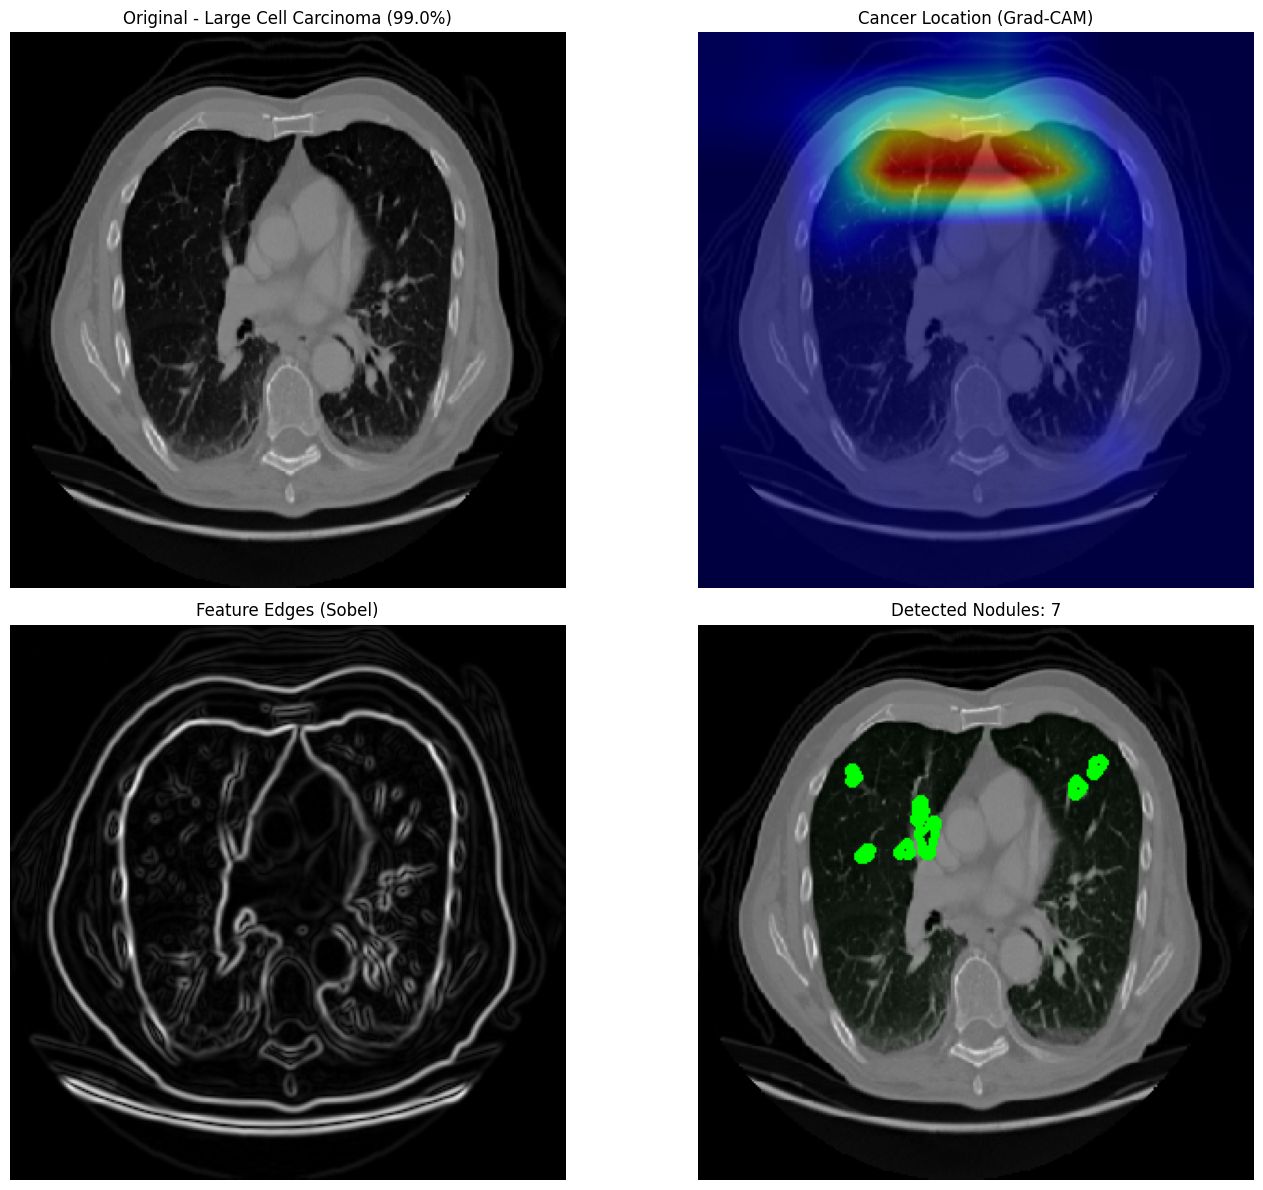


RECOMMENDATION:
Urgent follow-up required. Consult oncology specialist for comprehensive evaluation.


Analyzing image: /content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000148 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
CANCER DETECTED: Large Cell Carcinoma (Confidence: 99.59%)
Using layer: block14_sepconv2_act


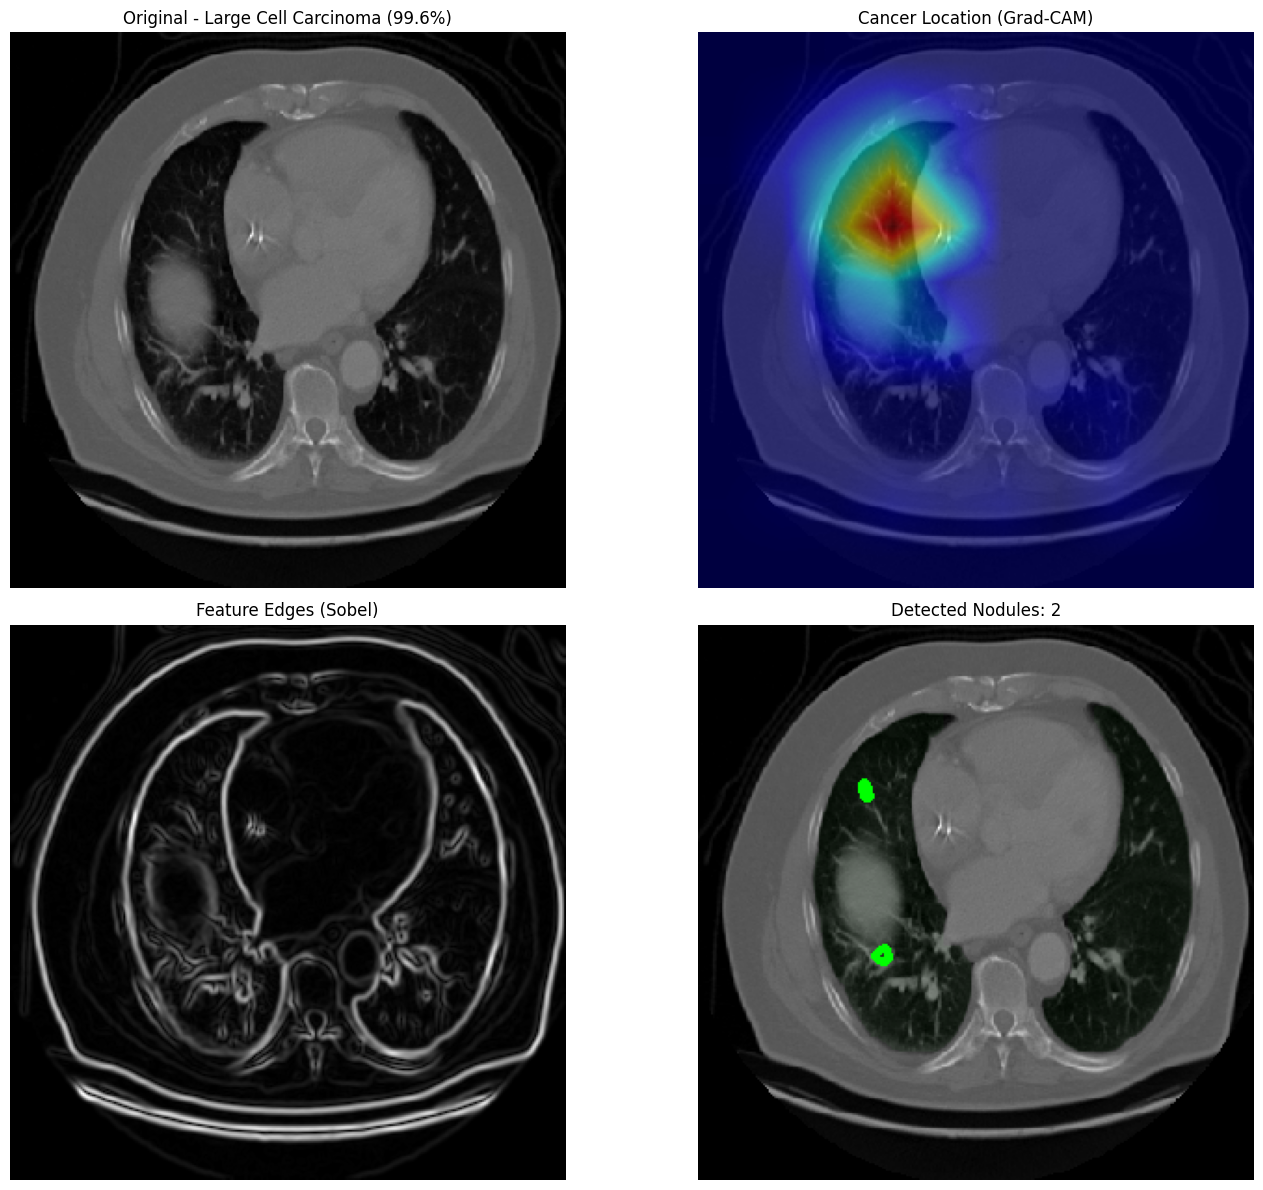


RECOMMENDATION:
Urgent follow-up required. Consult oncology specialist for comprehensive evaluation.


ANALYSIS SUMMARY:
Index  Classification            Confidence   Status
------ ------------------------- ------------ ----------
1      Large Cell Carcinoma      99.00%       CANCER DETECTED
2      Large Cell Carcinoma      99.59%       CANCER DETECTED


[{'prediction': 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
  'display_name': 'Large Cell Carcinoma',
  'confidence': np.float32(98.99888),
  'is_normal': False,
  'nodules_detected': 7},
 {'prediction': 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
  'display_name': 'Large Cell Carcinoma',
  'confidence': np.float32(99.585526),
  'is_normal': False,
  'nodules_detected': 2}]

In [24]:
batch_analyze(["/content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000159 (2).png", "/content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000148 (2).png"])

In [25]:
# Lung Cancer Detection Visualization for Google Colab
# Copy and paste this entire code into a Colab notebook

# Install required packages
#!pip install tensorflow opencv-python matplotlib scikit-image

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import cv2
import os
from google.colab import files, drive
import io
from PIL import Image

# Mount Google Drive (where your model is stored)
drive.mount('/content/drive')

# Class names and display names
class_names = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
               'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
               'normal',
               'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

display_names = {
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'Adenocarcinoma',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'Large Cell Carcinoma',
    'normal': 'Normal',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'Squamous Cell Carcinoma'
}

# Image size - must match model's input size
IMAGE_SIZE = (299, 299)

# Load the model (adjust path if needed)
model_path = '/content/drive/MyDrive/lung_cancer_model.keras'
print(f"Loading model from {model_path}...")

try:
    model = load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please check if the model file exists at the specified path.")
    print("You may need to upload your model to Google Drive first.")

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    """Load and preprocess an image for model input"""
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img_display = np.array(img).astype(np.uint8)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img_display

# Function to generate Grad-CAM
def generate_gradcam(model, img_array, layer_name=None):
    """Generate Grad-CAM heatmap for localization"""
    # Find the last convolutional layer if not specified
    if layer_name is None:
        # Try common Xception layer names
        potential_layers = ['block14_sepconv2_act', 'block13_sepconv2_act', 'conv2d_4']
        for layer in potential_layers:
            try:
                model.get_layer(layer)
                layer_name = layer
                print(f"Using layer: {layer_name}")
                break
            except:
                continue

        # If still not found, search for any conv layer
        if layer_name is None:
            for layer in reversed(model.layers):
                if 'conv' in layer.name.lower():
                    layer_name = layer.name
                    print(f"Using layer: {layer_name}")
                    break

    # Create grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Extract gradients and feature map
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight and combine feature maps
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

# Function to segment lung regions
def segment_lungs(image):
    """Segment lung regions from CT image to prevent false positives outside lungs"""
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Apply threshold to separate air (dark) from tissue (bright)
    # Use Otsu's method to find optimal threshold
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Apply morphological operations to clean up noise
    kernel = np.ones((5,5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create lung mask
    lung_mask = np.zeros_like(binary)

    if len(contours) > 0:
        # Sort contours by area (descending)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        # The largest contour is likely the body outline, skip it
        # The next largest contours are probably the lungs
        for i in range(1, min(4, len(contours))):
            area = cv2.contourArea(contours[i])
            # Only include contours that are reasonably sized for lungs
            if area > 1000 and area < gray.size * 0.5:
                cv2.drawContours(lung_mask, [contours[i]], -1, 255, -1)

        # If no lung contours found, use a fallback approach
        if np.sum(lung_mask) == 0:
            # Use binary image but remove border regions
            lung_mask = binary.copy()
            border_width = 20
            lung_mask[:border_width, :] = 0
            lung_mask[-border_width:, :] = 0
            lung_mask[:, :border_width] = 0
            lung_mask[:, -border_width:] = 0

    # Fill holes in the lung mask (nodules inside lungs may appear as holes)
    # Create a copy of the mask for hole filling
    filled_mask = lung_mask.copy()
    h, w = filled_mask.shape
    seed_mask = np.zeros((h+2, w+2), dtype=np.uint8)
    cv2.floodFill(filled_mask, seed_mask, (0, 0), 255)
    filled_mask = cv2.bitwise_not(filled_mask)
    filled_lung_mask = lung_mask | filled_mask

    return filled_lung_mask

# Detect nodules in image
def detect_nodules(img, is_normal=False, min_area=30, max_area=1500, circularity_threshold=0.6, heatmap=None):
    """Improved nodule detection with better Grad-CAM integration"""
    if is_normal:
        h, w = img.shape[:2] if len(img.shape) > 2 else img.shape
        return np.zeros((h, w), dtype=np.uint8), []

    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()

    # First segment the lungs
    lung_mask = segment_lungs(img)

    # Process heatmap if available
    if heatmap is not None:
        # Resize heatmap to match img size
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        # Create a weighted mask based on heatmap intensity
        # This prioritizes detecting nodules in high-activation areas
        heatmap_mask = np.zeros_like(gray, dtype=np.float32)

        # Set different thresholds to prioritize higher activation areas
        high_activity = (heatmap_resized > 0.5)   # Top 50% activation
        medium_activity = (heatmap_resized > 0.3) # Top 30-50% activation

        # Weight the mask by activation level
        heatmap_mask[high_activity] = 1.0         # Highest priority
        heatmap_mask[medium_activity] = 0.7       # Medium priority

        # Apply dilation to high activity areas
        kernel_high = np.ones((25, 25), np.uint8)
        high_dilated = cv2.dilate((high_activity*255).astype(np.uint8), kernel_high, iterations=1)

        # Create a combined mask focusing on high activity lung regions
        priority_mask = cv2.bitwise_and(lung_mask, high_dilated)

        # If priority mask is too small, expand to medium activity areas
        if np.sum(priority_mask) < 1000:
            kernel_med = np.ones((35, 35), np.uint8)
            med_dilated = cv2.dilate((medium_activity*255).astype(np.uint8), kernel_med, iterations=1)
            priority_mask = cv2.bitwise_and(lung_mask, med_dilated)
    else:
        # Without heatmap, use only lung mask
        priority_mask = lung_mask
        heatmap_mask = np.ones_like(gray, dtype=np.float32)

    # Apply contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Apply median blur to reduce noise but preserve edges
    blurred = cv2.medianBlur(enhanced, 5)

    # Apply adaptive thresholding with parameters tuned for medical imaging
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 3
    )

    # Apply priority mask to focus detection on high-activation lung areas
    thresh = cv2.bitwise_and(thresh, thresh, mask=priority_mask)

    # Clean up with morphological operations
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours of potential nodules
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours using multiple criteria and heatmap weighting
    filtered_contours = []
    candidate_scores = []  # To store "importance score" for each contour

    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # Get contour shape metrics
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)

                # Only consider circular-ish shapes
                if circularity > circularity_threshold:
                    # Create a mask for this contour
                    contour_mask = np.zeros_like(gray)
                    cv2.drawContours(contour_mask, [contour], -1, 255, -1)

                    # Check if mostly inside the lung
                    overlap = cv2.bitwise_and(contour_mask, lung_mask)
                    if np.sum(overlap) >= 0.8 * np.sum(contour_mask):
                        # Calculate "importance score" based on heatmap activation
                        # Get average activation value in this contour region
                        if heatmap is not None:
                            avg_activation = np.mean(heatmap_resized[contour_mask > 0])
                            importance = avg_activation * circularity * (1.0 - area/max_area)
                        else:
                            importance = circularity * (1.0 - area/max_area)

                        filtered_contours.append(contour)
                        candidate_scores.append(importance)

    # If too many nodules detected, keep only the highest scoring ones
    max_nodules = 6  # Cap on number of nodules to show
    if len(filtered_contours) > max_nodules:
        # Sort contours by importance score
        sorted_pairs = sorted(zip(filtered_contours, candidate_scores),
                              key=lambda x: x[1], reverse=True)
        # Keep only the top ones
        filtered_contours = [pair[0] for pair in sorted_pairs[:max_nodules]]

    # Create mask of nodules
    nodule_mask = np.zeros_like(gray)
    cv2.drawContours(nodule_mask, filtered_contours, -1, 255, -1)

    return nodule_mask, filtered_contours

# Apply Sobel gradient for edge detection
def apply_sobel_gradient(image):
    """Apply Sobel operator for edge detection"""
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Sobel operator in x and y directions
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Combine for gradient magnitude
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    magnitude = np.uint8(255 * magnitude / np.max(magnitude))

    return magnitude

# Main function to analyze CT image
def analyze_ct_image(img_path, save_results=False, output_path=None):
    """Analyze a lung CT image with comprehensive visualizations"""
    print(f"Analyzing image: {img_path}")

    # Load and preprocess the image
    img_array, img_display = load_and_preprocess_image(img_path)

    # Get predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100
    predicted_label = class_names[predicted_class]
    display_label = display_names.get(predicted_label, predicted_label)

    # Check if the image is classified as normal
    is_normal = (predicted_label == 'normal')

    # Create figure for visualization
    plt.figure(figsize=(15, 12))

    # Original image
    plt.subplot(2, 2, 1)
    plt.imshow(img_display)
    plt.title(f"Original - {display_label} ({confidence:.1f}%)")
    plt.axis('off')

    # If cancer is detected, show detailed visualizations
    if not is_normal:
        print(f"CANCER DETECTED: {display_label} (Confidence: {confidence:.2f}%)")

        # Generate Grad-CAM heatmap
        heatmap = generate_gradcam(model, img_array)
        heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
        heatmap_colored = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        # Create Grad-CAM overlay
        alpha = 0.5
        gradcam_overlay = img_display.copy()
        gradcam_overlay = cv2.addWeighted(heatmap_colored, alpha, gradcam_overlay, 1-alpha, 0)

        # Generate Sobel gradient
        sobel_result = apply_sobel_gradient(img_display)

        # Apply nodule detection with lung segmentation
        nodule_mask, nodule_contours = detect_nodules(img_display, is_normal=is_normal, heatmap=heatmap)

        # Visualize lung mask for debugging
        lung_mask = segment_lungs(img_display)

        # Draw contours on original image
        nodule_highlight = img_display.copy()

        # Overlay lung mask with transparency
        lung_overlay = np.zeros_like(nodule_highlight)
        lung_overlay[lung_mask > 0] = [0, 50, 0]  # Very light green tint
        nodule_highlight = cv2.addWeighted(nodule_highlight, 1, lung_overlay, 0.15, 0)

        # Draw nodule contours
        cv2.drawContours(nodule_highlight, nodule_contours, -1, (0, 255, 0), 3)

        # Add debug overlays to help visualize what's happening
        debug_img = img_display.copy()
        heatmap_mask = np.zeros_like(debug_img)
        heatmap_mask[heatmap_resized > 0.2] = [255, 0, 0]  # Red overlay
        debug_img = cv2.addWeighted(debug_img, 1, heatmap_mask, 0.3, 0)

        # Display visualizations
        plt.subplot(2, 2, 2)
        plt.imshow(gradcam_overlay)
        plt.title("Cancer Location (Grad-CAM)")
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(sobel_result, cmap='gray')
        plt.title("Feature Edges (Sobel)")
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(nodule_highlight)
        plt.title(f"Detected Nodules: {len(nodule_contours)}")
        plt.axis('off')

    else:
        print(f"Classification: {display_label} (Confidence: {confidence:.2f}%)")
        print("No cancer detected")

        # For normal classification, show the confidence chart
        plt.subplot(2, 2, 2)
        display_labels = [display_names.get(name, name) for name in class_names]
        bars = plt.barh(display_labels, predictions[0] * 100)
        plt.xlabel('Confidence (%)')
        plt.title('Prediction Confidence by Class')
        plt.xlim(0, 100)

        # Add percentage labels to bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
                    ha='left', va='center')

    plt.tight_layout()

    # Save results if requested
    if save_results and output_path:
        plt.savefig(output_path)
        print(f"Results saved to {output_path}")

    plt.show()

    # Show recommendation based on classification
    if not is_normal:
        print("\nRECOMMENDATION:")
        if "adenocarcinoma" in predicted_label:
            print("Further examination recommended. Consider CT with contrast and oncology consultation.")
        elif "large.cell.carcinoma" in predicted_label:
            print("Urgent follow-up required. Consult oncology specialist for comprehensive evaluation.")
        elif "squamous.cell.carcinoma" in predicted_label:
            print("Immediate follow-up recommended. Further imaging and biopsy may be required.")
    else:
        print("\nRECOMMENDATION:")
        print("No signs of cancer detected. Regular screening as per age and risk factor guidelines.")

    return {
        "prediction": predicted_label,
        "display_name": display_label,
        "confidence": confidence,
        "is_normal": is_normal,
        "nodules_detected": 0 if is_normal else len(nodule_contours) if 'nodule_contours' in locals() else 0
    }

# Function to upload and analyze an image
def upload_and_analyze():
    """Upload an image from local computer and analyze it"""
    print("Please upload a CT scan image...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Analyzing {filename}...")
        file_path = filename
        results = analyze_ct_image(file_path)

        print("\nSUMMARY:")
        print(f"Classification: {results['display_name']}")
        print(f"Confidence: {results['confidence']:.2f}%")
        print(f"Status: {'NORMAL' if results['is_normal'] else 'CANCER DETECTED'}")
        if not results['is_normal']:
            print(f"Nodules detected: {results['nodules_detected']}")

# Batch analysis for multiple images
def batch_analyze(image_paths):
    """Analyze multiple images and provide a summary"""
    results = []

    for img_path in image_paths:
        print(f"\n{'='*50}")
        result = analyze_ct_image(img_path)
        results.append(result)
        print(f"{'='*50}\n")

    # Print summary
    print("\nANALYSIS SUMMARY:")
    print(f"{'Index':<6} {'Classification':<25} {'Confidence':<12} {'Status'}")
    print(f"{'-'*6:<6} {'-'*25:<25} {'-'*12:<12} {'-'*10}")

    for i, result in enumerate(results):
        status = "NORMAL" if result["is_normal"] else "CANCER DETECTED"
        print(f"{i+1:<6} {result['display_name']:<25} {result['confidence']:.2f}%       {status}")

    return results

# Function to analyze a sample from drive
def analyze_from_drive(file_path):
    """Analyze a file from Google Drive"""
    full_path = os.path.join('/content/drive', file_path)
    if not os.path.exists(full_path):
        print(f"File not found: {full_path}")
        print("Please provide a valid path relative to your Google Drive")
        return

    return analyze_ct_image(full_path)

# Display UI options
print("\n==== LUNG CANCER DETECTION VISUALIZATION ====")
print("Choose an option:")
print("1. Run 'upload_and_analyze()' to upload and analyze your own image")
print("2. Run 'analyze_from_drive(\"path/to/image.png\")' to analyze an image from Google Drive")
print("3. Run 'batch_analyze([\"path/to/image1.png\", \"path/to/image2.png\"])' to analyze multiple images")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from /content/drive/MyDrive/lung_cancer_model.keras...
Model loaded successfully!

==== LUNG CANCER DETECTION VISUALIZATION ====
Choose an option:
1. Run 'upload_and_analyze()' to upload and analyze your own image
2. Run 'analyze_from_drive("path/to/image.png")' to analyze an image from Google Drive
3. Run 'batch_analyze(["path/to/image1.png", "path/to/image2.png"])' to analyze multiple images



Analyzing image: /content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000159 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
CANCER DETECTED: Large Cell Carcinoma (Confidence: 99.00%)
Using layer: block14_sepconv2_act


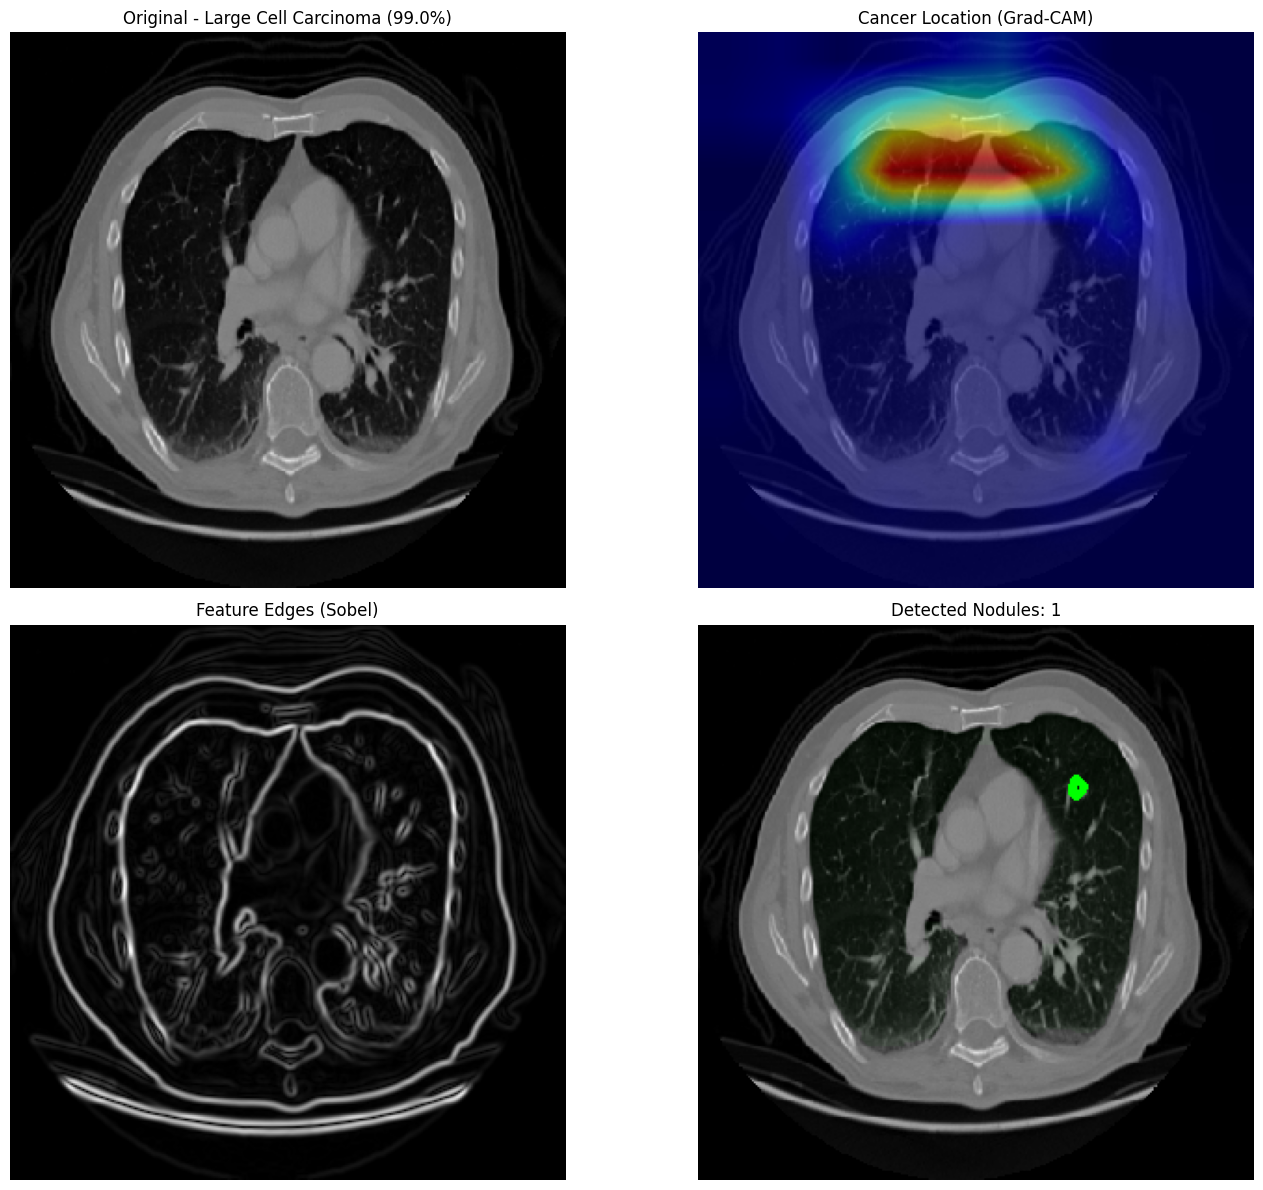


RECOMMENDATION:
Urgent follow-up required. Consult oncology specialist for comprehensive evaluation.


Analyzing image: /content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000148 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
CANCER DETECTED: Large Cell Carcinoma (Confidence: 99.59%)
Using layer: block14_sepconv2_act


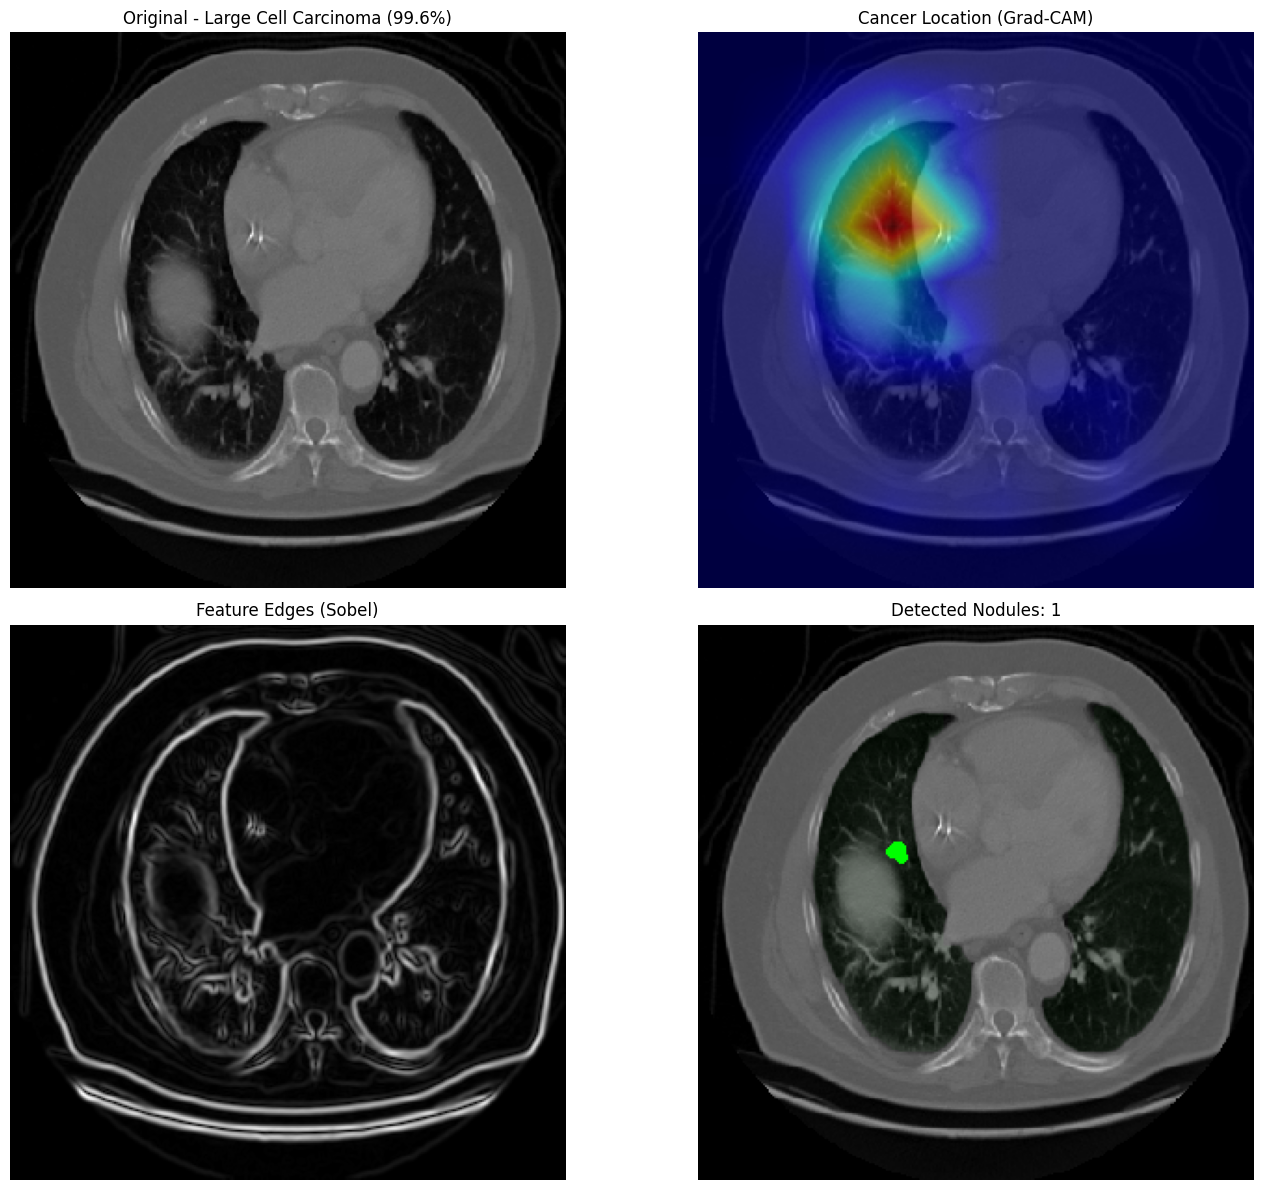


RECOMMENDATION:
Urgent follow-up required. Consult oncology specialist for comprehensive evaluation.


ANALYSIS SUMMARY:
Index  Classification            Confidence   Status
------ ------------------------- ------------ ----------
1      Large Cell Carcinoma      99.00%       CANCER DETECTED
2      Large Cell Carcinoma      99.59%       CANCER DETECTED


[{'prediction': 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
  'display_name': 'Large Cell Carcinoma',
  'confidence': np.float32(98.99888),
  'is_normal': False,
  'nodules_detected': 1},
 {'prediction': 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
  'display_name': 'Large Cell Carcinoma',
  'confidence': np.float32(99.585526),
  'is_normal': False,
  'nodules_detected': 1}]

In [26]:
batch_analyze(["/content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000159 (2).png", "/content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000148 (2).png"])

In [27]:
# Lung Cancer Detection Visualization for Google Colab
# Copy and paste this entire code into a Colab notebook

# Install required packages
#!pip install tensorflow opencv-python matplotlib scikit-image

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import cv2
import os
from google.colab import files, drive
import io
from PIL import Image
from skimage import morphology, measure, segmentation, filters
from scipy import ndimage
import scipy.stats as stats

# Mount Google Drive (where your model is stored)
drive.mount('/content/drive')

# Class names and display names
class_names = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
               'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
               'normal',
               'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

display_names = {
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'Adenocarcinoma',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'Large Cell Carcinoma',
    'normal': 'Normal',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'Squamous Cell Carcinoma'
}

# Image size - must match model's input size
IMAGE_SIZE = (299, 299)

# Load the model (adjust path if needed)
model_path = '/content/drive/MyDrive/lung_cancer_model.keras'
print(f"Loading model from {model_path}...")

try:
    model = load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please check if the model file exists at the specified path.")
    print("You may need to upload your model to Google Drive first.")

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    """Load and preprocess an image for model input"""
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img_display = np.array(img).astype(np.uint8)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img_display

# Function to generate Grad-CAM
def generate_gradcam(model, img_array, layer_name=None):
    """Generate Grad-CAM heatmap for localization"""
    # Find the last convolutional layer if not specified
    if layer_name is None:
        # Try common Xception layer names
        potential_layers = ['block14_sepconv2_act', 'block13_sepconv2_act', 'conv2d_4']
        for layer in potential_layers:
            try:
                model.get_layer(layer)
                layer_name = layer
                print(f"Using layer: {layer_name}")
                break
            except:
                continue

        # If still not found, search for any conv layer
        if layer_name is None:
            for layer in reversed(model.layers):
                if 'conv' in layer.name.lower():
                    layer_name = layer.name
                    print(f"Using layer: {layer_name}")
                    break

    # Create grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Extract gradients and feature map
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight and combine feature maps
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

# Replace the segment_lungs function with this advanced version
def segment_lungs_advanced(image):
    """Advanced lung segmentation using multiple techniques"""
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Apply Gaussian blur to reduce noise while preserving edges
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply automatic thresholding using Otsu's method with binary inversion (lungs are dark)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Fill small holes and remove small objects
    # This helps clean up the segmentation
    binary = morphology.binary_closing(binary, morphology.disk(3))
    cleared = morphology.remove_small_objects(binary.astype(bool), min_size=100)

    # Label connected regions
    label_image = measure.label(cleared)

    # Get region properties
    regions = measure.regionprops(label_image)

    # Create empty mask
    lung_mask = np.zeros_like(gray, dtype=np.uint8)

    # Analyze regions to find lungs (typically 2 largest regions after body)
    if regions:
        # Sort regions by area (descending)
        sorted_regions = sorted(regions, key=lambda x: x.area, reverse=True)

        # Skip the largest region (likely the body/background)
        # Take the next 2-3 largest regions which are likely lungs
        lung_count = 0
        for i in range(1, min(5, len(sorted_regions))):
            region = sorted_regions[i]

            # Check if region could be a lung
            if region.area > 1000 and region.area < gray.size * 0.4:
                # Get region bounding box
                minr, minc, maxr, maxc = region.bbox

                # Check if region is in the center part of the image (where lungs should be)
                h, w = gray.shape
                center_region = (minc > w*0.1 and maxc < w*0.9 and minr > h*0.1 and maxr < h*0.9)

                # Check region's shape - lungs are typically elongated vertically
                aspect_ratio = (maxr - minr) / (maxc - minc) if (maxc - minc) > 0 else 0
                good_aspect = 0.5 < aspect_ratio < 3.0

                if center_region and good_aspect:
                    # Add region to lung mask
                    temp_mask = np.zeros_like(label_image)
                    temp_mask[label_image == region.label] = 255
                    lung_mask = np.bitwise_or(lung_mask, temp_mask.astype(np.uint8))
                    lung_count += 1

                    # Stop after finding 2 lungs
                    if lung_count >= 2:
                        break

    # If no good lung regions found, use fallback method
    if np.sum(lung_mask) < 1000:
        print("Using fallback lung segmentation...")
        # Remove border to focus on center where lungs should be
        h, w = gray.shape
        border_width = int(min(w, h) * 0.05)  # 5% border

        # Create a simple binary mask based on intensity
        fallback_mask = binary.copy()
        fallback_mask[:border_width, :] = 0
        fallback_mask[-border_width:, :] = 0
        fallback_mask[:, :border_width] = 0
        fallback_mask[:, -border_width:] = 0

        # Fill holes and clean up
        fallback_mask = ndimage.binary_fill_holes(fallback_mask).astype(np.uint8) * 255
        lung_mask = fallback_mask

    # Apply morphological operations to clean and connect lung regions
    kernel = np.ones((5,5), np.uint8)
    lung_mask = cv2.morphologyEx(lung_mask, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Fill holes (potential nodules) in the lung mask
    if np.sum(lung_mask) > 0:
        lung_mask = ndimage.binary_fill_holes(lung_mask > 0).astype(np.uint8) * 255

    return lung_mask

# Replace the detect_nodules function with this advanced version
def detect_nodules_advanced(img, is_normal=False, heatmap=None):
    """Advanced nodule detection with multi-level analysis and Grad-CAM integration"""
    if is_normal:
        h, w = img.shape[:2] if len(img.shape) > 2 else img.shape
        return np.zeros((h, w), dtype=np.uint8), []

    # Convert to grayscale while preserving original
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()

    # Use advanced lung segmentation
    lung_mask = segment_lungs_advanced(img)

    # Prepare heatmap for guidance if available
    if heatmap is not None:
        # Resize heatmap to match image dimensions
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        # Create multilevel activation masks
        activation_levels = {
            'high': (heatmap_resized > 0.6),     # Areas of highest attention
            'medium': (heatmap_resized > 0.3),   # Medium attention
            'low': (heatmap_resized > 0.1)       # Low attention
        }

        # Dilate activation regions based on level of attention
        dilated_activations = {}
        for level, mask in activation_levels.items():
            if np.any(mask):
                mask_uint8 = (mask * 255).astype(np.uint8)
                kernel_size = 25 if level == 'high' else 15 if level == 'medium' else 5
                kernel = np.ones((kernel_size, kernel_size), np.uint8)
                dilated = cv2.dilate(mask_uint8, kernel, iterations=2 if level == 'high' else 1)
                dilated_activations[level] = dilated
            else:
                dilated_activations[level] = np.zeros_like(gray, dtype=np.uint8)

        # Create priority regions focusing on activation within lungs
        priority_regions = {}
        for level in ['high', 'medium', 'low']:
            # Intersect activation with lung mask
            if level in dilated_activations:
                priority_regions[level] = cv2.bitwise_and(
                    dilated_activations[level],
                    dilated_activations[level],
                    mask=lung_mask
                )

        # If no high priority regions found within lungs, expand search to medium/low
        # This handles cases where model finds cancer outside anatomical lung area
        if np.sum(priority_regions.get('high', np.zeros_like(gray))) < 100:
            if np.sum(priority_regions.get('medium', np.zeros_like(gray))) > 100:
                priority_regions['high'] = priority_regions['medium']
            elif np.sum(priority_regions.get('low', np.zeros_like(gray))) > 100:
                priority_regions['high'] = priority_regions['low']
            else:
                # If still no match, use entire lung as search area
                priority_regions['high'] = lung_mask
    else:
        # Without heatmap, just use lung mask
        priority_regions = {'high': lung_mask}

    # Enhance image for nodule detection
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Multi-scale Nodule Detection Strategy
    # We'll detect nodules at different scales and resolutions

    # 1. Small nodule detection (sensitive parameters)
    small_nodules = []
    blurred_small = cv2.GaussianBlur(enhanced, (3, 3), 0)
    thresh_small = cv2.adaptiveThreshold(
        blurred_small, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2  # More sensitive
    )

    # Apply priority mask
    thresh_small = cv2.bitwise_and(
        thresh_small, thresh_small,
        mask=priority_regions['high']
    )

    # Cleanup and find contours
    opening_small = cv2.morphologyEx(
        thresh_small, cv2.MORPH_OPEN,
        np.ones((2,2), np.uint8), iterations=1
    )
    contours_small, _ = cv2.findContours(
        opening_small, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Filter small nodules
    for contour in contours_small:
        area = cv2.contourArea(contour)
        if 20 < area < 500:  # Small nodules
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.7:  # Small nodules tend to be more circular
                    # Create mask for this contour
                    contour_mask = np.zeros_like(gray)
                    cv2.drawContours(contour_mask, [contour], -1, 255, -1)

                    # Check if mostly inside lung
                    overlap = cv2.bitwise_and(contour_mask, lung_mask)
                    if np.sum(overlap) >= 0.9 * np.sum(contour_mask):
                        # Calculate center for distance from high activation
                        M = cv2.moments(contour)
                        if M["m00"] > 0:
                            cx = int(M["m10"] / M["m00"])
                            cy = int(M["m01"] / M["m00"])

                            # Calculate "importance score" based on activation
                            if heatmap is not None:
                                # Get region of interest
                                x, y, w, h = cv2.boundingRect(contour)
                                roi = heatmap_resized[y:y+h, x:x+w]
                                avg_activation = np.mean(roi) if roi.size > 0 else 0

                                # Score based on activation, circularity and distance from high activation
                                score = avg_activation * circularity * (1.0 - area/1000)
                            else:
                                score = circularity * (1.0 - area/1000)

                            small_nodules.append((contour, score))

    # 2. Medium nodule detection
    medium_nodules = []
    blurred_med = cv2.GaussianBlur(enhanced, (5, 5), 0)
    thresh_med = cv2.adaptiveThreshold(
        blurred_med, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 3  # Standard parameters
    )

    # Apply priority mask - medium nodules can be in wider area
    if 'medium' in priority_regions and np.sum(priority_regions['medium']) > 0:
        search_mask = cv2.bitwise_or(priority_regions['high'], priority_regions['medium'])
    else:
        search_mask = priority_regions['high']

    thresh_med = cv2.bitwise_and(thresh_med, thresh_med, mask=search_mask)

    # Cleanup and find contours
    opening_med = cv2.morphologyEx(
        thresh_med, cv2.MORPH_OPEN,
        np.ones((3,3), np.uint8), iterations=1
    )
    contours_med, _ = cv2.findContours(
        opening_med, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Filter medium nodules
    for contour in contours_med:
        area = cv2.contourArea(contour)
        if 200 < area < 2000:  # Medium nodules
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.5:  # Medium nodules can be less circular
                    # Create mask for this contour
                    contour_mask = np.zeros_like(gray)
                    cv2.drawContours(contour_mask, [contour], -1, 255, -1)

                    # Check if mostly inside lung
                    overlap = cv2.bitwise_and(contour_mask, lung_mask)
                    if np.sum(overlap) >= 0.8 * np.sum(contour_mask):
                        # Same scoring as before
                        if heatmap is not None:
                            x, y, w, h = cv2.boundingRect(contour)
                            roi = heatmap_resized[y:y+h, x:x+w]
                            avg_activation = np.mean(roi) if roi.size > 0 else 0
                            score = avg_activation * circularity * (1.0 - area/2000)
                        else:
                            score = circularity * (1.0 - area/2000)

                        medium_nodules.append((contour, score))

    # 3. Special focus on high activation regions - analyze intensities directly
    high_activation_nodules = []

    if heatmap is not None and np.any(activation_levels['high']):
        # Convert high activation mask to uint8
        high_mask = (activation_levels['high'] * 255).astype(np.uint8)

        # Apply lung mask to focus on high activation within lungs
        high_mask = cv2.bitwise_and(high_mask, high_mask, mask=lung_mask)

        if np.sum(high_mask) > 0:
            # Locate intensity anomalies in high activation regions
            roi_gray = cv2.bitwise_and(gray, gray, mask=high_mask)

            # Only analyze non-zero areas
            roi_vals = roi_gray[roi_gray > 0]

            if len(roi_vals) > 0:
                # Get intensity statistics
                mean_val = np.mean(roi_vals)
                std_val = np.std(roi_vals)

                # Threshold to find extreme intensities
                if std_val > 0:
                    intensity_thresh = mean_val + 1.5 * std_val
                    _, intensity_binary = cv2.threshold(roi_gray, intensity_thresh, 255, cv2.THRESH_BINARY)

                    # Find contours in intensity-based threshold
                    contours_int, _ = cv2.findContours(
                        intensity_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
                    )

                    # Filter these contours
                    for contour in contours_int:
                        area = cv2.contourArea(contour)
                        if 50 < area < 3000:  # Special nodules can be various sizes
                            high_activation_nodules.append((contour, 2.0))  # High priority

    # 4. Merge all nodule detections
    all_nodules = small_nodules + medium_nodules + high_activation_nodules

    # Filter to remove overlapping detections
    filtered_nodules = []
    if all_nodules:
        # Sort by score (descending)
        all_nodules.sort(key=lambda x: x[1], reverse=True)

        # Convert contours to masks for overlap checking
        contour_masks = []
        for contour, _ in all_nodules:
            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            contour_masks.append(mask)

        # Take highest scoring nodules first, remove overlapping ones
        used = set()
        for i, (contour, score) in enumerate(all_nodules):
            if i in used:
                continue

            filtered_nodules.append(contour)

            # Check for overlaps with this contour
            mask_i = contour_masks[i]
            for j in range(i+1, len(all_nodules)):
                if j in used:
                    continue

                mask_j = contour_masks[j]
                overlap = cv2.bitwise_and(mask_i, mask_j)
                if np.sum(overlap) > 0.5 * np.sum(mask_j):  # Over 50% overlap
                    used.add(j)  # Mark as overlapping

    # Limit to reasonable number
    max_nodules = 8
    if len(filtered_nodules) > max_nodules:
        filtered_nodules = filtered_nodules[:max_nodules]

    # Create final mask
    nodule_mask = np.zeros_like(gray)
    cv2.drawContours(nodule_mask, filtered_nodules, -1, 255, -1)

    return nodule_mask, filtered_nodules

# Apply Sobel gradient for edge detection
def apply_sobel_gradient(image):
    """Apply Sobel operator for edge detection"""
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Sobel operator in x and y directions
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Combine for gradient magnitude
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    magnitude = np.uint8(255 * magnitude / np.max(magnitude))

    return magnitude

# Main function to analyze CT image
def analyze_ct_image(img_path, save_results=False, output_path=None):
    """Analyze a lung CT image with comprehensive visualizations"""
    print(f"Analyzing image: {img_path}")

    # Load and preprocess the image
    img_array, img_display = load_and_preprocess_image(img_path)

    # Get predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100
    predicted_label = class_names[predicted_class]
    display_label = display_names.get(predicted_label, predicted_label)

    # Check if the image is classified as normal
    is_normal = (predicted_label == 'normal')

    # Create figure for visualization
    plt.figure(figsize=(15, 12))

    # Original image
    plt.subplot(2, 2, 1)
    plt.imshow(img_display)
    plt.title(f"Original - {display_label} ({confidence:.1f}%)")
    plt.axis('off')

    # If cancer is detected, show detailed visualizations
    if not is_normal:
        print(f"CANCER DETECTED: {display_label} (Confidence: {confidence:.2f}%)")

        # Generate Grad-CAM heatmap
        heatmap = generate_gradcam(model, img_array)
        heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
        heatmap_colored = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        # Create Grad-CAM overlay
        alpha = 0.5
        gradcam_overlay = img_display.copy()
        gradcam_overlay = cv2.addWeighted(heatmap_colored, alpha, gradcam_overlay, 1-alpha, 0)

        # Generate Sobel gradient
        sobel_result = apply_sobel_gradient(img_display)

        # Apply nodule detection with lung segmentation
        nodule_mask, nodule_contours = detect_nodules_advanced(img_display, is_normal=is_normal, heatmap=heatmap)

        # Visualize lung mask for debugging
        lung_mask = segment_lungs_advanced(img_display)

        # Draw contours on original image
        nodule_highlight = img_display.copy()

        # Overlay lung mask with transparency
        lung_overlay = np.zeros_like(nodule_highlight)
        lung_overlay[lung_mask > 0] = [0, 50, 0]  # Very light green tint
        nodule_highlight = cv2.addWeighted(nodule_highlight, 1, lung_overlay, 0.15, 0)

        # Draw nodule contours
        cv2.drawContours(nodule_highlight, nodule_contours, -1, (0, 255, 0), 3)

        # Add debug overlays to help visualize what's happening
        debug_img = img_display.copy()
        heatmap_mask = np.zeros_like(debug_img)
        heatmap_mask[heatmap_resized > 0.2] = [255, 0, 0]  # Red overlay
        debug_img = cv2.addWeighted(debug_img, 1, heatmap_mask, 0.3, 0)

        # Display visualizations
        plt.subplot(2, 2, 2)
        plt.imshow(gradcam_overlay)
        plt.title("Cancer Location (Grad-CAM)")
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(sobel_result, cmap='gray')
        plt.title("Feature Edges (Sobel)")
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(nodule_highlight)
        plt.title(f"Detected Nodules: {len(nodule_contours)}")
        plt.axis('off')

        # Create enhanced visualization showing alignment between Grad-CAM and nodules
        plt.figure(figsize=(12, 12))
        plt.title(f"Enhanced Visualization - {display_label} ({confidence:.1f}%)")

        # Create fusion image
        fusion_img = img_display.copy()

        # Add Grad-CAM heatmap with transparency
        heatmap_overlay = np.zeros_like(fusion_img, dtype=np.float32)
        heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))

        # Apply colormap to heatmap with proper normalization
        heatmap_colored = cv2.applyColorMap(
            (heatmap_resized * 255).astype(np.uint8),
            cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        # Add heatmap with transparency
        alpha_heatmap = 0.4  # Adjust transparency
        fusion_img = cv2.addWeighted(
            heatmap_colored, alpha_heatmap,
            fusion_img, 1 - alpha_heatmap, 0
        )

        # Highlight nodules with green contours
        cv2.drawContours(fusion_img, nodule_contours, -1, (0, 255, 0), 3)

        # Add text annotations
        for i, contour in enumerate(nodule_contours):
            # Get center of contour
            M = cv2.moments(contour)
            if M["m00"] > 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Draw label
                cv2.putText(
                    fusion_img, f"#{i+1}", (cx, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2
                )

        # Display enhanced visualization
        plt.imshow(fusion_img)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('/content/enhanced_visualization.jpg', dpi=300)
        plt.show()

    else:
        print(f"Classification: {display_label} (Confidence: {confidence:.2f}%)")
        print("No cancer detected")

        # For normal classification, show the confidence chart
        plt.subplot(2, 2, 2)
        display_labels = [display_names.get(name, name) for name in class_names]
        bars = plt.barh(display_labels, predictions[0] * 100)
        plt.xlabel('Confidence (%)')
        plt.title('Prediction Confidence by Class')
        plt.xlim(0, 100)

        # Add percentage labels to bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
                    ha='left', va='center')

    plt.tight_layout()

    # Save results if requested
    if save_results and output_path:
        plt.savefig(output_path)
        print(f"Results saved to {output_path}")

    plt.show()

    # Show recommendation based on classification
    if not is_normal:
        print("\nRECOMMENDATION:")
        if "adenocarcinoma" in predicted_label:
            print("Further examination recommended. Consider CT with contrast and oncology consultation.")
        elif "large.cell.carcinoma" in predicted_label:
            print("Urgent follow-up required. Consult oncology specialist for comprehensive evaluation.")
        elif "squamous.cell.carcinoma" in predicted_label:
            print("Immediate follow-up recommended. Further imaging and biopsy may be required.")
    else:
        print("\nRECOMMENDATION:")
        print("No signs of cancer detected. Regular screening as per age and risk factor guidelines.")

    return {
        "prediction": predicted_label,
        "display_name": display_label,
        "confidence": confidence,
        "is_normal": is_normal,
        "nodules_detected": 0 if is_normal else len(nodule_contours) if 'nodule_contours' in locals() else 0
    }

# Function to upload and analyze an image
def upload_and_analyze():
    """Upload an image from local computer and analyze it"""
    print("Please upload a CT scan image...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Analyzing {filename}...")
        file_path = filename
        results = analyze_ct_image(file_path)

        print("\nSUMMARY:")
        print(f"Classification: {results['display_name']}")
        print(f"Confidence: {results['confidence']:.2f}%")
        print(f"Status: {'NORMAL' if results['is_normal'] else 'CANCER DETECTED'}")
        if not results['is_normal']:
            print(f"Nodules detected: {results['nodules_detected']}")

# Batch analysis for multiple images
def batch_analyze(image_paths):
    """Analyze multiple images and provide a summary"""
    results = []

    for img_path in image_paths:
        print(f"\n{'='*50}")
        result = analyze_ct_image(img_path)
        results.append(result)
        print(f"{'='*50}\n")

    # Print summary
    print("\nANALYSIS SUMMARY:")
    print(f"{'Index':<6} {'Classification':<25} {'Confidence':<12} {'Status'}")
    print(f"{'-'*6:<6} {'-'*25:<25} {'-'*12:<12} {'-'*10}")

    for i, result in enumerate(results):
        status = "NORMAL" if result["is_normal"] else "CANCER DETECTED"
        print(f"{i+1:<6} {result['display_name']:<25} {result['confidence']:.2f}%       {status}")

    return results

# Function to analyze a sample from drive
def analyze_from_drive(file_path):
    """Analyze a file from Google Drive"""
    full_path = os.path.join('/content/drive', file_path)
    if not os.path.exists(full_path):
        print(f"File not found: {full_path}")
        print("Please provide a valid path relative to your Google Drive")
        return

    return analyze_ct_image(full_path)

# Display UI options
print("\n==== LUNG CANCER DETECTION VISUALIZATION ====")
print("Choose an option:")
print("1. Run 'upload_and_analyze()' to upload and analyze your own image")
print("2. Run 'analyze_from_drive(\"path/to/image.png\")' to analyze an image from Google Drive")
print("3. Run 'batch_analyze([\"path/to/image1.png\", \"path/to/image2.png\"])' to analyze multiple images")




#Correct one

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from /content/drive/MyDrive/lung_cancer_model.keras...
Model loaded successfully!

==== LUNG CANCER DETECTION VISUALIZATION ====
Choose an option:
1. Run 'upload_and_analyze()' to upload and analyze your own image
2. Run 'analyze_from_drive("path/to/image.png")' to analyze an image from Google Drive
3. Run 'batch_analyze(["path/to/image1.png", "path/to/image2.png"])' to analyze multiple images


In [ ]:
batch_analyze(["/content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000159 (2).png", "/content/drive/MyDrive/dataset/test/normal/6.png"])

In [ ]:
upload_and_analyze()

In [ ]:
analyze_from_drive("/content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000159 (2).png")

In [41]:
# Lung Cancer Detection Visualization for Google Colab
# Copy and paste this entire code into a Colab notebook

# Install required packages
#!pip install tensorflow opencv-python matplotlib scikit-image

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import cv2
import os
from google.colab import files, drive
import io
from PIL import Image
from skimage import morphology, measure, segmentation, filters
from scipy import ndimage
import scipy.stats as stats

# Mount Google Drive (where your model is stored)
drive.mount('/content/drive')

# Class names and display names
class_names = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
               'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
               'normal',
               'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

display_names = {
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'Adenocarcinoma',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'Large Cell Carcinoma',
    'normal': 'Normal',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'Squamous Cell Carcinoma'
}

# Image size - must match model's input size
IMAGE_SIZE = (299, 299)

# Load the model (adjust path if needed)
model_path = '/content/drive/MyDrive/lung_cancer_model.keras'
print(f"Loading model from {model_path}...")

try:
    model = load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please check if the model file exists at the specified path.")
    print("You may need to upload your model to Google Drive first.")

# Function to load and preprocess an image
def load_and_preprocess_image(img_path):
    """Load and preprocess an image for model input"""
    img = load_img(img_path, target_size=IMAGE_SIZE)
    img_display = np.array(img).astype(np.uint8)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img_display

# Function to generate Grad-CAM
def generate_gradcam(model, img_array, layer_name=None):
    """Generate Grad-CAM heatmap for localization"""
    # Find the last convolutional layer if not specified
    if layer_name is None:
        # Try common Xception layer names
        potential_layers = ['block14_sepconv2_act', 'block13_sepconv2_act', 'conv2d_4']
        for layer in potential_layers:
            try:
                model.get_layer(layer)
                layer_name = layer
                print(f"Using layer: {layer_name}")
                break
            except:
                continue

        # If still not found, search for any conv layer
        if layer_name is None:
            for layer in reversed(model.layers):
                if 'conv' in layer.name.lower():
                    layer_name = layer.name
                    print(f"Using layer: {layer_name}")
                    break

    # Create grad model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Extract gradients and feature map
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight and combine feature maps
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    return heatmap

# Replace the segment_lungs function with this advanced version
def segment_lungs_advanced(image):
    """Advanced lung segmentation using multiple techniques"""
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Apply Gaussian blur to reduce noise while preserving edges
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply automatic thresholding using Otsu's method with binary inversion (lungs are dark)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Fill small holes and remove small objects
    # This helps clean up the segmentation
    binary = morphology.binary_closing(binary, morphology.disk(3))
    cleared = morphology.remove_small_objects(binary.astype(bool), min_size=100)

    # Label connected regions
    label_image = measure.label(cleared)

    # Get region properties
    regions = measure.regionprops(label_image)

    # Create empty mask
    lung_mask = np.zeros_like(gray, dtype=np.uint8)

    # Analyze regions to find lungs (typically 2 largest regions after body)
    if regions:
        # Sort regions by area (descending)
        sorted_regions = sorted(regions, key=lambda x: x.area, reverse=True)

        # Skip the largest region (likely the body/background)
        # Take the next 2-3 largest regions which are likely lungs
        lung_count = 0
        for i in range(1, min(5, len(sorted_regions))):
            region = sorted_regions[i]

            # Check if region could be a lung
            if region.area > 1000 and region.area < gray.size * 0.4:
                # Get region bounding box
                minr, minc, maxr, maxc = region.bbox

                # Check if region is in the center part of the image (where lungs should be)
                h, w = gray.shape
                center_region = (minc > w*0.1 and maxc < w*0.9 and minr > h*0.1 and maxr < h*0.9)

                # Check region's shape - lungs are typically elongated vertically
                aspect_ratio = (maxr - minr) / (maxc - minc) if (maxc - minc) > 0 else 0
                good_aspect = 0.5 < aspect_ratio < 3.0

                if center_region and good_aspect:
                    # Add region to lung mask
                    temp_mask = np.zeros_like(label_image)
                    temp_mask[label_image == region.label] = 255
                    lung_mask = np.bitwise_or(lung_mask, temp_mask.astype(np.uint8))
                    lung_count += 1

                    # Stop after finding 2 lungs
                    if lung_count >= 2:
                        break

    # If no good lung regions found, use fallback method
    if np.sum(lung_mask) < 1000:
        print("Using fallback lung segmentation...")
        # Remove border to focus on center where lungs should be
        h, w = gray.shape
        border_width = int(min(w, h) * 0.05)  # 5% border

        # Create a simple binary mask based on intensity
        fallback_mask = binary.copy()
        fallback_mask[:border_width, :] = 0
        fallback_mask[-border_width:, :] = 0
        fallback_mask[:, :border_width] = 0
        fallback_mask[:, -border_width:] = 0

        # Fill holes and clean up
        fallback_mask = ndimage.binary_fill_holes(fallback_mask).astype(np.uint8) * 255
        lung_mask = fallback_mask

    # Apply morphological operations to clean and connect lung regions
    kernel = np.ones((5,5), np.uint8)
    lung_mask = cv2.morphologyEx(lung_mask, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Fill holes (potential nodules) in the lung mask
    if np.sum(lung_mask) > 0:
        lung_mask = ndimage.binary_fill_holes(lung_mask > 0).astype(np.uint8) * 255

    return lung_mask

# Replace the detect_nodules function with this advanced version
def detect_nodules_advanced(img, is_normal=False, heatmap=None):
    """Advanced nodule detection with multi-level analysis and Grad-CAM integration"""
    if is_normal:
        h, w = img.shape[:2] if len(img.shape) > 2 else img.shape
        return np.zeros((h, w), dtype=np.uint8), []

    # Convert to grayscale while preserving original
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()

    # Use advanced lung segmentation
    lung_mask = segment_lungs_advanced(img)

    # Prepare heatmap for guidance if available
    if heatmap is not None:
        # Resize heatmap to match image dimensions
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        # Create multilevel activation masks
        activation_levels = {
            'high': (heatmap_resized > 0.6),     # Areas of highest attention
            'medium': (heatmap_resized > 0.3),   # Medium attention
            'low': (heatmap_resized > 0.1)       # Low attention
        }

        # Dilate activation regions based on level of attention
        dilated_activations = {}
        for level, mask in activation_levels.items():
            if np.any(mask):
                mask_uint8 = (mask * 255).astype(np.uint8)
                kernel_size = 25 if level == 'high' else 15 if level == 'medium' else 5
                kernel = np.ones((kernel_size, kernel_size), np.uint8)
                dilated = cv2.dilate(mask_uint8, kernel, iterations=2 if level == 'high' else 1)
                dilated_activations[level] = dilated
            else:
                dilated_activations[level] = np.zeros_like(gray, dtype=np.uint8)

        # Create priority regions focusing on activation within lungs
        priority_regions = {}
        for level in ['high', 'medium', 'low']:
            # Intersect activation with lung mask
            if level in dilated_activations:
                priority_regions[level] = cv2.bitwise_and(
                    dilated_activations[level],
                    dilated_activations[level],
                    mask=lung_mask
                )

        # If no high priority regions found within lungs, expand search to medium/low
        # This handles cases where model finds cancer outside anatomical lung area
        if np.sum(priority_regions.get('high', np.zeros_like(gray))) < 100:
            if np.sum(priority_regions.get('medium', np.zeros_like(gray))) > 100:
                priority_regions['high'] = priority_regions['medium']
            elif np.sum(priority_regions.get('low', np.zeros_like(gray))) > 100:
                priority_regions['high'] = priority_regions['low']
            else:
                # If still no match, use entire lung as search area
                priority_regions['high'] = lung_mask
    else:
        # Without heatmap, just use lung mask
        priority_regions = {'high': lung_mask}

    # Enhance image for nodule detection
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Multi-scale Nodule Detection Strategy
    # We'll detect nodules at different scales and resolutions

    # 1. Small nodule detection (sensitive parameters)
    small_nodules = []
    blurred_small = cv2.GaussianBlur(enhanced, (3, 3), 0)
    thresh_small = cv2.adaptiveThreshold(
        blurred_small, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2  # More sensitive
    )

    # Apply priority mask
    thresh_small = cv2.bitwise_and(
        thresh_small, thresh_small,
        mask=priority_regions['high']
    )

    # Cleanup and find contours
    opening_small = cv2.morphologyEx(
        thresh_small, cv2.MORPH_OPEN,
        np.ones((2,2), np.uint8), iterations=1
    )
    contours_small, _ = cv2.findContours(
        opening_small, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Filter small nodules
    for contour in contours_small:
        area = cv2.contourArea(contour)
        if 20 < area < 500:  # Small nodules
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.7:  # Small nodules tend to be more circular
                    # Create mask for this contour
                    contour_mask = np.zeros_like(gray)
                    cv2.drawContours(contour_mask, [contour], -1, 255, -1)

                    # Check if mostly inside lung
                    overlap = cv2.bitwise_and(contour_mask, lung_mask)
                    if np.sum(overlap) >= 0.9 * np.sum(contour_mask):
                        # Calculate center for distance from high activation
                        M = cv2.moments(contour)
                        if M["m00"] > 0:
                            cx = int(M["m10"] / M["m00"])
                            cy = int(M["m01"] / M["m00"])

                            # Calculate "importance score" based on activation
                            if heatmap is not None:
                                # Get region of interest
                                x, y, w, h = cv2.boundingRect(contour)
                                roi = heatmap_resized[y:y+h, x:x+w]
                                avg_activation = np.mean(roi) if roi.size > 0 else 0

                                # Score based on activation, circularity and distance from high activation
                                score = avg_activation * circularity * (1.0 - area/1000)
                            else:
                                score = circularity * (1.0 - area/1000)

                            small_nodules.append((contour, score))

    # 2. Medium nodule detection
    medium_nodules = []
    blurred_med = cv2.GaussianBlur(enhanced, (5, 5), 0)
    thresh_med = cv2.adaptiveThreshold(
        blurred_med, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 15, 3  # Standard parameters
    )

    # Apply priority mask - medium nodules can be in wider area
    if 'medium' in priority_regions and np.sum(priority_regions['medium']) > 0:
        search_mask = cv2.bitwise_or(priority_regions['high'], priority_regions['medium'])
    else:
        search_mask = priority_regions['high']

    thresh_med = cv2.bitwise_and(thresh_med, thresh_med, mask=search_mask)

    # Cleanup and find contours
    opening_med = cv2.morphologyEx(
        thresh_med, cv2.MORPH_OPEN,
        np.ones((3,3), np.uint8), iterations=1
    )
    contours_med, _ = cv2.findContours(
        opening_med, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Filter medium nodules
    for contour in contours_med:
        area = cv2.contourArea(contour)
        if 200 < area < 2000:  # Medium nodules
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.5:  # Medium nodules can be less circular
                    # Create mask for this contour
                    contour_mask = np.zeros_like(gray)
                    cv2.drawContours(contour_mask, [contour], -1, 255, -1)

                    # Check if mostly inside lung
                    overlap = cv2.bitwise_and(contour_mask, lung_mask)
                    if np.sum(overlap) >= 0.8 * np.sum(contour_mask):
                        # Same scoring as before
                        if heatmap is not None:
                            x, y, w, h = cv2.boundingRect(contour)
                            roi = heatmap_resized[y:y+h, x:x+w]
                            avg_activation = np.mean(roi) if roi.size > 0 else 0
                            score = avg_activation * circularity * (1.0 - area/2000)
                        else:
                            score = circularity * (1.0 - area/2000)

                        medium_nodules.append((contour, score))

    # 3. Special focus on high activation regions - analyze intensities directly
    high_activation_nodules = []

    if heatmap is not None and np.any(activation_levels['high']):
        # Convert high activation mask to uint8
        high_mask = (activation_levels['high'] * 255).astype(np.uint8)

        # Apply lung mask to focus on high activation within lungs
        high_mask = cv2.bitwise_and(high_mask, high_mask, mask=lung_mask)

        if np.sum(high_mask) > 0:
            # Locate intensity anomalies in high activation regions
            roi_gray = cv2.bitwise_and(gray, gray, mask=high_mask)

            # Only analyze non-zero areas
            roi_vals = roi_gray[roi_gray > 0]

            if len(roi_vals) > 0:
                # Get intensity statistics
                mean_val = np.mean(roi_vals)
                std_val = np.std(roi_vals)

                # Threshold to find extreme intensities
                if std_val > 0:
                    intensity_thresh = mean_val + 1.5 * std_val
                    _, intensity_binary = cv2.threshold(roi_gray, intensity_thresh, 255, cv2.THRESH_BINARY)

                    # Find contours in intensity-based threshold
                    contours_int, _ = cv2.findContours(
                        intensity_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
                    )

                    # Filter these contours
                    for contour in contours_int:
                        area = cv2.contourArea(contour)
                        if 50 < area < 3000:  # Special nodules can be various sizes
                            high_activation_nodules.append((contour, 2.0))  # High priority

    # 4. Merge all nodule detections
    all_nodules = small_nodules + medium_nodules + high_activation_nodules

    # Filter to remove overlapping detections
    filtered_nodules = []
    if all_nodules:
        # Sort by score (descending)
        all_nodules.sort(key=lambda x: x[1], reverse=True)

        # Convert contours to masks for overlap checking
        contour_masks = []
        for contour, _ in all_nodules:
            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            contour_masks.append(mask)

        # Take highest scoring nodules first, remove overlapping ones
        used = set()
        for i, (contour, score) in enumerate(all_nodules):
            if i in used:
                continue

            filtered_nodules.append(contour)

            # Check for overlaps with this contour
            mask_i = contour_masks[i]
            for j in range(i+1, len(all_nodules)):
                if j in used:
                    continue

                mask_j = contour_masks[j]
                overlap = cv2.bitwise_and(mask_i, mask_j)
                if np.sum(overlap) > 0.5 * np.sum(mask_j):  # Over 50% overlap
                    used.add(j)  # Mark as overlapping

    # Limit to reasonable number
    max_nodules = 8
    if len(filtered_nodules) > max_nodules:
        filtered_nodules = filtered_nodules[:max_nodules]

    # Create final mask
    nodule_mask = np.zeros_like(gray)
    cv2.drawContours(nodule_mask, filtered_nodules, -1, 255, -1)

    return nodule_mask, filtered_nodules

# Apply Sobel gradient for edge detection
def apply_sobel_gradient(image):
    """Apply Sobel operator for edge detection"""
    # Convert to grayscale if RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Sobel operator in x and y directions
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Combine for gradient magnitude
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    magnitude = np.uint8(255 * magnitude / np.max(magnitude))

    return magnitude

# Main function to analyze CT image
def analyze_ct_image(img_path, save_results=False, output_path=None):
    """Analyze a lung CT image with comprehensive visualizations"""
    print(f"Analyzing image: {img_path}")

    # Load and preprocess the image
    img_array, img_display = load_and_preprocess_image(img_path)

    # Get predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class] * 100
    predicted_label = class_names[predicted_class]
    display_label = display_names.get(predicted_label, predicted_label)

    # Check if the image is classified as normal
    is_normal = (predicted_label == 'normal')

    # Create figure for visualization - now making it 2x3 instead of 2x2
    plt.figure(figsize=(16, 12))

    # Original image always shown
    plt.subplot(2, 3, 1)
    plt.imshow(img_display)
    plt.title(f"Original - {display_label} ({confidence:.1f}%)")
    plt.axis('off')

    # Confidence chart ALWAYS shown (for all cases)
    plt.subplot(2, 3, 2)
    display_labels = [display_names.get(name, name) for name in class_names]
    bars = plt.barh(display_labels, predictions[0] * 100)
    plt.xlabel('Confidence (%)')
    plt.title('Prediction Confidence by Class')
    plt.xlim(0, 100)

    # Add percentage labels to bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
                ha='left', va='center')

    # If cancer is detected, also show detailed visualizations
    if not is_normal:
        print(f"CANCER DETECTED: {display_label} (Confidence: {confidence:.2f}%)")

        # Generate Grad-CAM heatmap
        heatmap = generate_gradcam(model, img_array)
        heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
        heatmap_colored = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_colored, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        # Create Grad-CAM overlay
        alpha = 0.5
        gradcam_overlay = img_display.copy()
        gradcam_overlay = cv2.addWeighted(heatmap_colored, alpha, gradcam_overlay, 1-alpha, 0)

        # Generate Sobel gradient
        sobel_result = apply_sobel_gradient(img_display)

        # Apply nodule detection
        nodule_mask, nodule_contours = detect_nodules_advanced(img_display, is_normal=is_normal, heatmap=heatmap)

        # Draw contours on original image
        nodule_highlight = img_display.copy()
        cv2.drawContours(nodule_highlight, nodule_contours, -1, (0, 255, 0), 3)

        # Display visualizations in remaining slots
        plt.subplot(2, 3, 3)
        plt.imshow(gradcam_overlay)
        plt.title("Cancer Location (Grad-CAM)")
        plt.axis('off')

        plt.subplot(2, 3, 4)
        plt.imshow(sobel_result, cmap='gray')
        plt.title("Feature Edges (Sobel)")
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(nodule_highlight)
        plt.title(f"Detected Nodules: {len(nodule_contours)}")
        plt.axis('off')

        # Optional: Add a 6th subplot for enhanced visualization or stats
        plt.subplot(2, 3, 6)
        # Create fusion image showing both Grad-CAM and nodules
        fusion_img = img_display.copy()
        fusion_img = cv2.addWeighted(heatmap_colored, 0.4, fusion_img, 0.6, 0)
        cv2.drawContours(fusion_img, nodule_contours, -1, (0, 255, 0), 3)
        plt.imshow(fusion_img)
        plt.title("Fused Analysis")
        plt.axis('off')

    else:
        print(f"Classification: {display_label} (Confidence: {confidence:.2f}%)")
        print("No cancer detected")

        # For normal classification, show empty plots or additional normal case info
        plt.subplot(2, 3, 3)
        plt.text(0.5, 0.5, "No Cancer Detected",
                horizontalalignment='center', verticalalignment='center',
                fontsize=14, color='green')
        plt.axis('off')

        plt.subplot(2, 3, 4)
        plt.text(0.5, 0.5, "Normal Lung Tissue",
                horizontalalignment='center', verticalalignment='center',
                fontsize=14, color='green')
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.text(0.5, 0.5, "No Nodules Detected",
                horizontalalignment='center', verticalalignment='center',
                fontsize=14, color='green')
        plt.axis('off')

    plt.tight_layout()

    # Save results if requested
    if save_results and output_path:
        plt.savefig(output_path)
        print(f"Results saved to {output_path}")

    plt.show()

    # Show recommendation based on classification
    if not is_normal:
        print("\nRECOMMENDATION:")
        if "adenocarcinoma" in predicted_label:
            print("Further examination recommended. Consider CT with contrast and oncology consultation.")
        elif "large.cell.carcinoma" in predicted_label:
            print("Urgent follow-up required. Consult oncology specialist for comprehensive evaluation.")
        elif "squamous.cell.carcinoma" in predicted_label:
            print("Immediate follow-up recommended. Further imaging and biopsy may be required.")
    else:
        print("\nRECOMMENDATION:")
        print("No signs of cancer detected. Regular screening as per age and risk factor guidelines.")

    return {
        "prediction": predicted_label,
        "display_name": display_label,
        "confidence": confidence,
        "is_normal": is_normal,
        "nodules_detected": 0 if is_normal else len(nodule_contours) if 'nodule_contours' in locals() else 0
    }

# Function to upload and analyze an image
def upload_and_analyze():
    """Upload an image from local computer and analyze it"""
    print("Please upload a CT scan image...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Analyzing {filename}...")
        file_path = filename
        results = analyze_ct_image(file_path)

        print("\nSUMMARY:")
        print(f"Classification: {results['display_name']}")
        print(f"Confidence: {results['confidence']:.2f}%")
        print(f"Status: {'NORMAL' if results['is_normal'] else 'CANCER DETECTED'}")
        if not results['is_normal']:
            print(f"Nodules detected: {results['nodules_detected']}")

# Batch analysis for multiple images
def batch_analyze(image_paths):
    """Analyze multiple images and provide a summary"""
    results = []

    for img_path in image_paths:
        print(f"\n{'='*50}")
        result = analyze_ct_image(img_path)
        results.append(result)
        print(f"{'='*50}\n")

    # Print summary
    print("\nANALYSIS SUMMARY:")
    print(f"{'Index':<6} {'Classification':<25} {'Confidence':<12} {'Status'}")
    print(f"{'-'*6:<6} {'-'*25:<25} {'-'*12:<12} {'-'*10}")

    for i, result in enumerate(results):
        status = "NORMAL" if result["is_normal"] else "CANCER DETECTED"
        print(f"{i+1:<6} {result['display_name']:<25} {result['confidence']:.2f}%       {status}")

    return results

# Function to analyze a sample from drive
def analyze_from_drive(file_path):
    """Analyze a file from Google Drive"""
    full_path = os.path.join('/content/drive', file_path)
    if not os.path.exists(full_path):
        print(f"File not found: {full_path}")
        print("Please provide a valid path relative to your Google Drive")
        return

    return analyze_ct_image(full_path)

# Display UI options
print("\n==== LUNG CANCER DETECTION VISUALIZATION ====")
print("Choose an option:")
print("1. Run 'upload_and_analyze()' to upload and analyze your own image")
print("2. Run 'analyze_from_drive(\"path/to/image.png\")' to analyze an image from Google Drive")
print("3. Run 'batch_analyze([\"path/to/image1.png\", \"path/to/image2.png\"])' to analyze multiple images")



# Correct one with confidence graph

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading model from /content/drive/MyDrive/lung_cancer_model.keras...
Model loaded successfully!

==== LUNG CANCER DETECTION VISUALIZATION ====
Choose an option:
1. Run 'upload_and_analyze()' to upload and analyze your own image
2. Run 'analyze_from_drive("path/to/image.png")' to analyze an image from Google Drive
3. Run 'batch_analyze(["path/to/image1.png", "path/to/image2.png"])' to analyze multiple images


In [ ]:
analyze_from_drive("/content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000159 (2).png")


Analyzing image: /content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000159 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
CANCER DETECTED: Large Cell Carcinoma (Confidence: 99.00%)
Using layer: block14_sepconv2_act


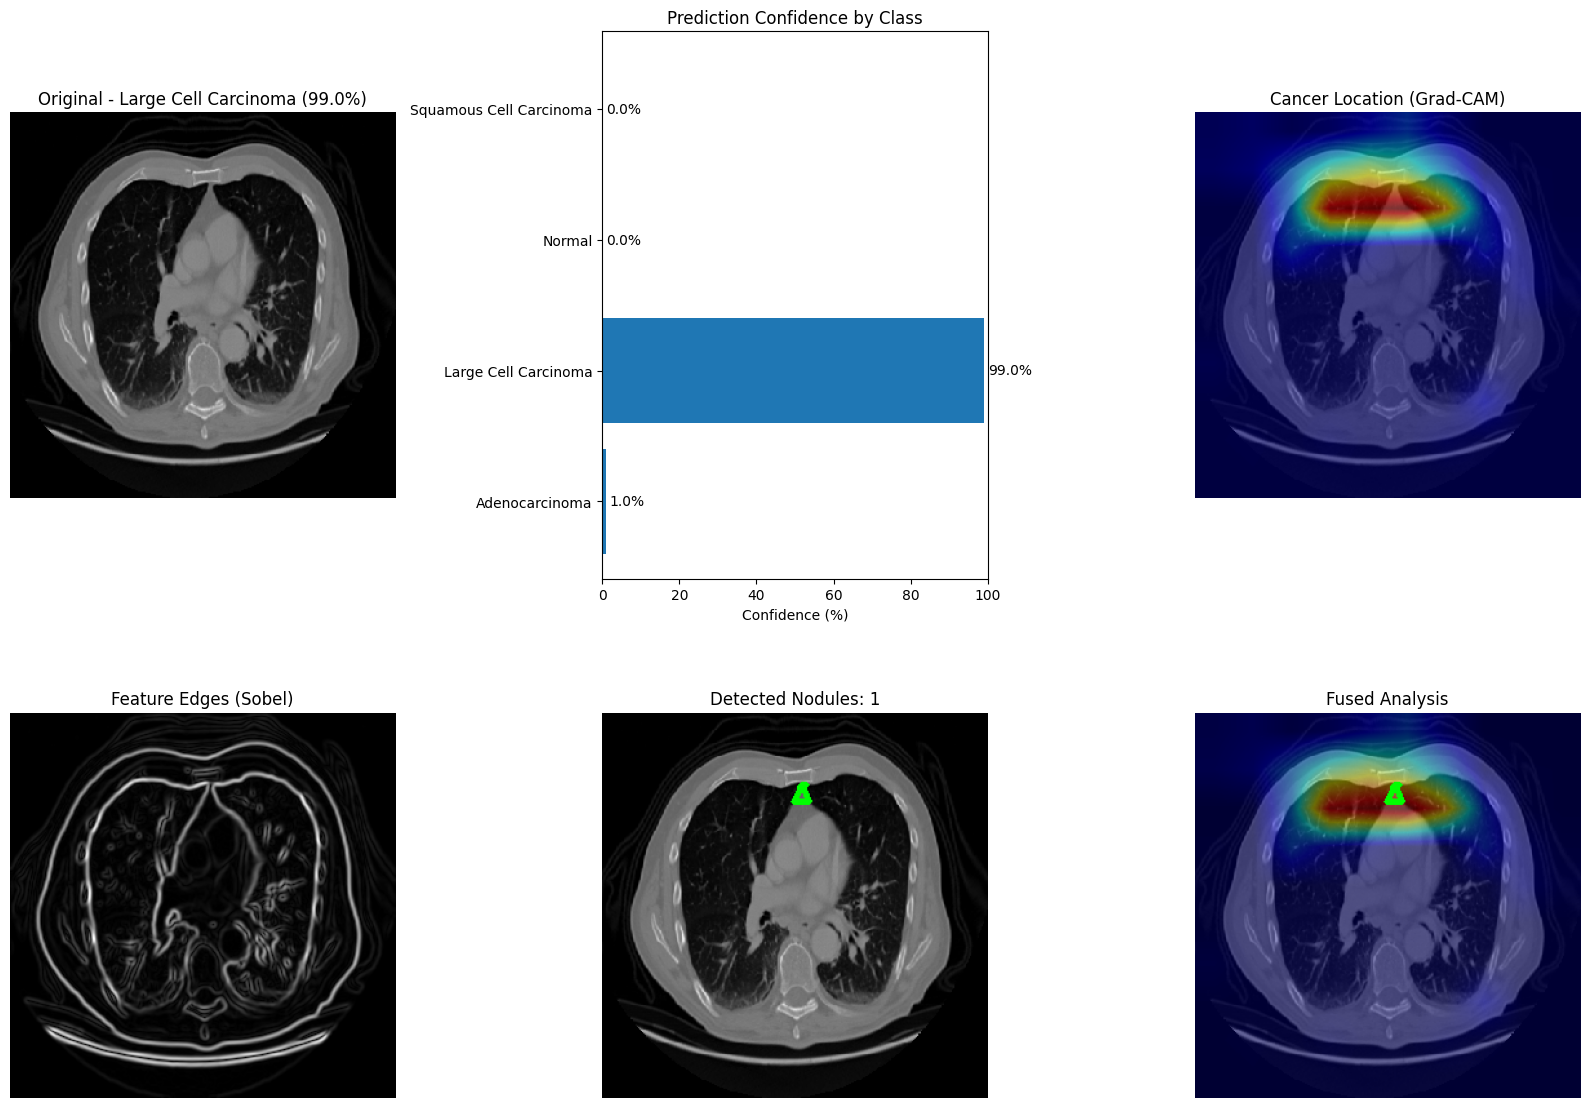


RECOMMENDATION:
Urgent follow-up required. Consult oncology specialist for comprehensive evaluation.


Analyzing image: /content/drive/MyDrive/dataset/test/normal/6.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
Classification: Normal (Confidence: 99.98%)
No cancer detected


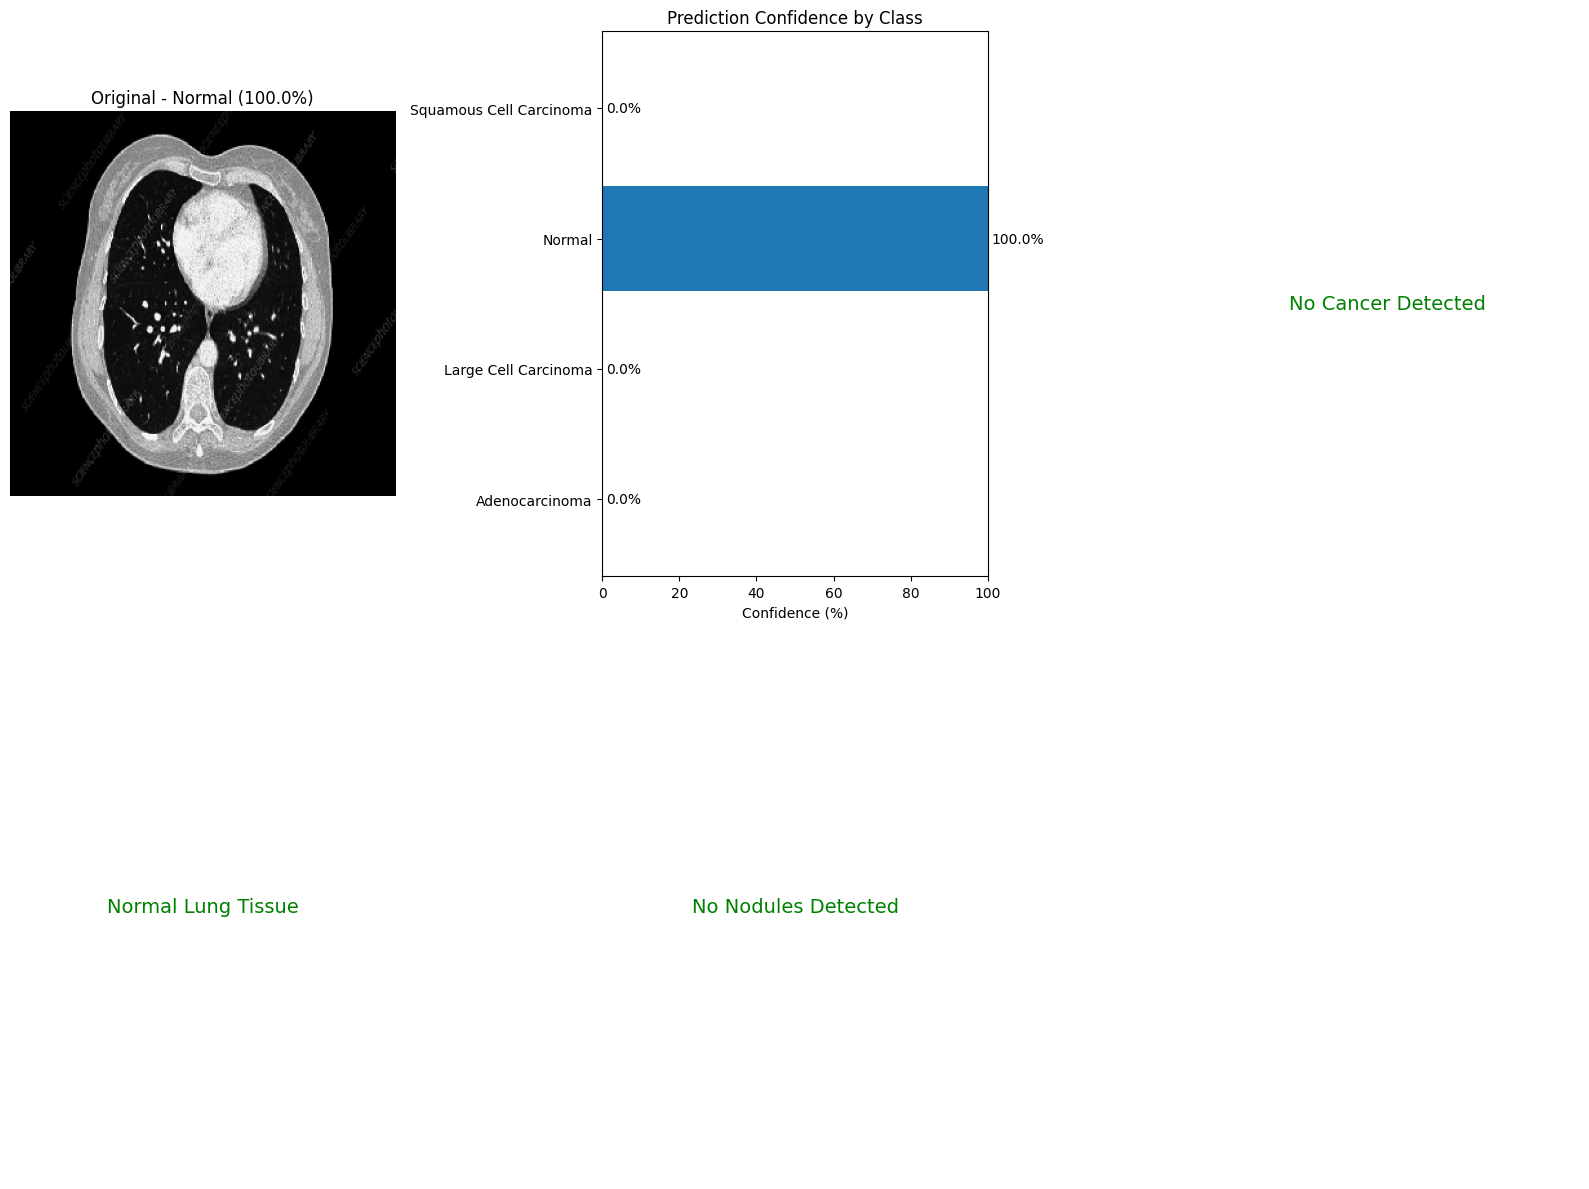


RECOMMENDATION:
No signs of cancer detected. Regular screening as per age and risk factor guidelines.


ANALYSIS SUMMARY:
Index  Classification            Confidence   Status
------ ------------------------- ------------ ----------
1      Large Cell Carcinoma      99.00%       CANCER DETECTED
2      Normal                    99.98%       NORMAL


[{'prediction': 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
  'display_name': 'Large Cell Carcinoma',
  'confidence': np.float32(98.99888),
  'is_normal': False,
  'nodules_detected': 1},
 {'prediction': 'normal',
  'display_name': 'Normal',
  'confidence': np.float32(99.984764),
  'is_normal': True,
  'nodules_detected': 0}]

In [43]:
batch_analyze(["/content/drive/MyDrive/dataset/test/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000159 (2).png", "/content/drive/MyDrive/dataset/test/normal/6.png"])